In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor, ceil, sqrt
from sklearn.model_selection import train_test_split
import time as time

totaltime1 = time.time()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

## Data Preparation

In [2]:
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
NUMBER_OF_INTERVALS = 1_800 # = 1_800_000 msec / 250 milisecond intervals

NUM_FEATURES = 14
NUM_FEATURES_2 = 54
FINAL_LAYER_COUNT = 12

EVENT_MAX = 6000
WORD_MAX = 800
PASTE_COUNT_DIVISOR = 10
REPLACE_COUNT_DIVISOR = 10

def ScoreOneHot(score: float) -> np.array:
    result = np.zeros(12)
    result[int(score / 0.5) - 1] = 1
    return result

def TrainingPrep(df: pd.DataFrame):

    indexs_to_drop = df[df["down_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)
    indexs_to_drop = df[df["up_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)

    return df

def DfToX(df: pd.DataFrame, minPositiveExamples: int = 0) -> np.array:
    indexs_to_drop = df[df["action_time"] > 250].index
    df = df.drop(indexs_to_drop, axis=0)
    NumUniqueIds = len(np.unique(df["id"]))

    x_train_1 = np.zeros((NumUniqueIds, NUM_FEATURES, int(NUMBER_OF_INTERVALS)))
    x_train_2 = np.zeros((NumUniqueIds, NUM_FEATURES_2))
    
    groups = df.groupby("id")

    for index, id in enumerate(np.unique(df["id"])):
        essayGroup = groups.get_group(id)
        max = essayGroup["down_time"].quantile(0.99)
        min = essayGroup["down_time"].quantile(0.01)
        dt_range = max - min
        if dt_range == 0:
            dt_range = 1
        if dt_range is None:
            dt_range = 1

        MAX_CURSOR_POSITION = essayGroup["cursor_position"].max()

        if MAX_CURSOR_POSITION is None:
            print("MAX_CURSOR_POSITION is None")

        ValueActivityCounts = essayGroup.activity.value_counts().reset_index()
        ValueEventCounts = essayGroup.down_event.value_counts().reset_index()
        ValueTextChangeCounts = essayGroup.text_change.value_counts().reset_index()

        SpaceStats = essayGroup[["id", "down_event", "event_id"]]
        SpaceStats = SpaceStats[SpaceStats["down_event"].isin(["Space"])]
        SpaceStats["word_size"] = SpaceStats["event_id"].diff()
        SpaceStats = SpaceStats.dropna(axis=0).reset_index()

        x_train_2[index][0] = essayGroup.word_count.max() / WORD_MAX
        x_train_2[index][1] = essayGroup.event_id.max() / EVENT_MAX
        x_train_2[index][2] = essayGroup.down_time.min() / 60_000

        x_train_2[index][3] = essayGroup.activity.count() / 6000
        x_train_2[index][4] = ValueActivityCounts[ValueActivityCounts["activity"] == "Input"]["count"].max() / 6000
        x_train_2[index][5] = ValueActivityCounts[ValueActivityCounts["activity"] == "Remove/Cut"]["count"].max() / 700
        x_train_2[index][6] = ValueActivityCounts[ValueActivityCounts["activity"] == "Paste"]["count"].max() / PASTE_COUNT_DIVISOR
        x_train_2[index][7] = ValueActivityCounts[ValueActivityCounts["activity"] == "Replace"]["count"].max() / REPLACE_COUNT_DIVISOR

        x_train_2[index][8] = ((x_train_2[index][7] * REPLACE_COUNT_DIVISOR) + (x_train_2[index][6] * PASTE_COUNT_DIVISOR)) / (PASTE_COUNT_DIVISOR + REPLACE_COUNT_DIVISOR)
        
        x_train_2[index][9] = ValueEventCounts[ValueEventCounts["down_event"] == "Shift"]["count"].max() / 300
        x_train_2[index][10] = ValueEventCounts[ValueEventCounts["down_event"].isin(PUNCUATION)]["count"].sum() / 100
        x_train_2[index][11] = ValueEventCounts[ValueEventCounts["down_event"].isin(["Space", "CapsLock"])]["count"].sum() / 1000
        x_train_2[index][12] = ValueEventCounts[ValueEventCounts["down_event"].isin(["Leftclick", "ArrowUp", "ArrowDown", "ArrowLeft", "ArrowRight"])]["count"].sum() / 250
        x_train_2[index][13] = ValueEventCounts[ValueEventCounts["down_event"].isin(["?", "!"])]["count"].sum() / 10

        x_train_2[index][14] = essayGroup.action_time.mean() / 100
        x_train_2[index][15] = essayGroup.action_time.sum() / 500_000
        x_train_2[index][16] = essayGroup.action_time.std() / 100
        x_train_2[index][17] = essayGroup.action_time.skew() / 20

        x_train_2[index][18] = essayGroup.down_time.mean() / 100_000
        x_train_2[index][19] = essayGroup.down_time.sum() / 100_000_000
        x_train_2[index][20] = essayGroup.down_time.std() / 500_000
        x_train_2[index][21] = essayGroup.down_time.skew() / 20
        x_train_2[index][22] = essayGroup.down_time.sem() / 10_000

        x_train_2[index][23] = essayGroup.word_count.std() / 200
        x_train_2[index][24] = essayGroup.word_count.sem() / 3
        x_train_2[index][25] = essayGroup.word_count.mean() / 350

        for i in range(10):
            if i == 0 or i == 1:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 2500
            elif i == 2 or i == 3:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 500
            else:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 25

        x_train_2[index][36] = ValueEventCounts[ValueEventCounts["down_event"].isin(["AudioVolumeDown", "AudioVolumeMute", "AudioVolumeUp", "MediaPlayPause", "MediaTrackNext", "MediaTrackPrevious"])]["count"].sum() / 10
        x_train_2[index][37] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["q"])]["count"].sum() / 1000
        x_train_2[index][38] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin([" ", "\n"])]["count"].sum() / 1000
        x_train_2[index][39] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["NoChange"])]["count"].sum() / 500
        x_train_2[index][40] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["NoChange", " ", "\n", "q"])]["count"].sum() / 500
        x_train_2[index][41] = np.sum(list(map(lambda x: x.count("=>"), essayGroup['text_change'])))

        temp_diff = essayGroup.groupby("id")["down_time"].diff(periods=1, axis=0)   
        x_train_2[index][42] = essayGroup[temp_diff > 100].dropna().groupby("id")["event_id"].count().max() / 4000
        x_train_2[index][43] = essayGroup[temp_diff > 1_000].dropna().groupby("id")["event_id"].count().max() / 200
        x_train_2[index][44] = essayGroup[temp_diff > 10_000].dropna().groupby("id")["event_id"].count().max() / 20
        x_train_2[index][45] = essayGroup[temp_diff > 100_000].dropna().groupby("id")["event_id"].count().max() / 2
        del temp_diff

        x_train_2[index][46] = SpaceStats.word_size.mean() / 10
        x_train_2[index][47] = SpaceStats.word_size.sum() / 6000
        x_train_2[index][48] = SpaceStats.word_size.skew() / 10
        x_train_2[index][49] = SpaceStats.word_size.std() / 15
        x_train_2[index][50] = SpaceStats.word_size.sem() # / 1

        x_train_2[index][51] = np.sum(list(map(lambda x: x.count("Move From"), essayGroup['activity'])))
        x_train_2[index][52] = ValueActivityCounts[ValueActivityCounts["activity"] == "Nonproduction"]["count"].max() / 500
        x_train_2[index][53] = (ValueActivityCounts[ValueActivityCounts['activity'].isin(['Input', 'Remove/Cut'])]["count"].sum() /
                               (essayGroup.up_time.max() - essayGroup.down_time.min())) * 100

        for i in range(len(x_train_2[index])):
            if np.isnan(x_train_2[index][i]):
                x_train_2[index][i] = 0

        # Build X Train 1 (convolution)
        for row in essayGroup.itertuples():

            if (row.down_time < min*0.9) or (row.down_time > max*1.1):
                continue

            start_index = floor(((row.down_time - min) / dt_range) * NUMBER_OF_INTERVALS)

            if start_index >= NUMBER_OF_INTERVALS:
                start_index = NUMBER_OF_INTERVALS - 1

            if start_index < 0:
                start_index = 0
            
            match row.activity:
                case "Nonproduction":
                    x_train_1[index][2][start_index] += 1.0
                case "Input" | "Replace":
                    # Puncuation
                    if row.down_event in PUNCUATION:
                        x_train_1[index][6][start_index] += 1.0
                    elif row.down_event == "q":
                        x_train_1[index][7][start_index] += 1.0
                    else:
                        x_train_1[index][8][start_index] += 1.0

                case "Remove/Cut":
                    x_train_1[index][4][start_index] += 1.0
                case "Paste":
                    x_train_1[index][5][start_index] += 1.0
                case _:
                    if "Move From" in row.activity:
                        x_train_1[index][3][start_index] += 1.0
            
            if x_train_1[index][0][start_index] < (row.word_count / WORD_MAX):
                x_train_1[index][0][start_index] = (row.word_count / WORD_MAX)
            
            if x_train_1[index][1][start_index] < (row.cursor_position / MAX_CURSOR_POSITION):
                x_train_1[index][1][start_index] = (row.cursor_position / MAX_CURSOR_POSITION)
            
            if x_train_1[index][9][start_index] < (row.event_id / EVENT_MAX):
                x_train_1[index][9][start_index] = (row.event_id / EVENT_MAX)

            if row.action_time < 66: # Training 0-25%
                x_train_1[index][10][start_index] += 1.0
            elif row.action_time < 93: # Training 25-50%
                x_train_1[index][11][start_index] += 1.0
            elif row.action_time < 122: # Training 50-75%
                x_train_1[index][12][start_index] += 1.0
            else: # 75%+
                x_train_1[index][13][start_index] += 1.0

        currentWordCount = 0
        for i, wordCount in enumerate(np.nditer(x_train_1[index][0])):
            if wordCount == 0:
                x_train_1[index][0] = currentWordCount
            elif currentWordCount != wordCount:
                currentWordCount = wordCount

        currentCursorPosition = 0
        for i, cursor in enumerate(np.nditer(x_train_1[index][1])):
            if cursor == 0:
                x_train_1[index][1] = currentCursorPosition
            elif cursor != currentCursorPosition:
                currentCursorPosition = cursor

        currentEventCount = 0
        for i, event in enumerate(np.nditer(x_train_1[index][1])):
            if event == 0:
                x_train_1[index][9] = currentEventCount
            elif event != currentEventCount:
                currentEventCount = event
                
    while len(x_train_1) < minPositiveExamples:
        randomExample1 = GenerateNewExample(x_train=x_train_1)
        randomExample2 = GenerateNewExample(x_train=x_train_2)
        x_train_1 = np.concatenate((x_train_1, [randomExample1]))
        x_train_2 = np.concatenate((x_train_2, [randomExample2]))

    x_train_1 = np.transpose(x_train_1, axes=(0, 2, 1))
    return x_train_1, x_train_2

def GenerateNewExample(x_train: np.array):
    example_index = np.random.choice(len(x_train), 1)[0]
    Noise = (0.005 * np.random.sample(x_train[0].shape)) - 0.0025
    result = x_train[example_index] *  (1 + Noise)
    return result

In [3]:
TrainingPrep(train_logs)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [4]:
score_labels, score_counts = np.unique(train_scores.score, return_counts=True)

train_x_1 = dict(zip(score_labels, [np.zeros((floor(count - (0.2*count)), NUM_FEATURES, int(NUMBER_OF_INTERVALS))) for count in score_counts]))
test_x_1 = dict(zip(score_labels, [np.zeros((floor(0.2*count), NUM_FEATURES, int(NUMBER_OF_INTERVALS))) for count in score_counts]))

train_x_2 = dict(zip(score_labels, [np.zeros((floor(count - (0.2*count)), NUM_FEATURES, int(NUMBER_OF_INTERVALS))) for count in score_counts]))
test_x_2 = dict(zip(score_labels, [np.zeros((floor(0.2*count), NUM_FEATURES, int(NUMBER_OF_INTERVALS))) for count in score_counts]))


for score_index, score in enumerate(score_labels):
    count = score_counts[score_index]
    ids = train_scores[train_scores["score"] == (score)]
    temp_train_x_1, temp_train_x_2 = DfToX(train_logs[train_logs["id"].isin(ids.id)], minPositiveExamples=50)

    cutoff = floor(count*0.2)
    train_x_1[score] = temp_train_x_1[cutoff:]
    test_x_1[score] = temp_train_x_1[:cutoff]

    train_x_2[score] = temp_train_x_2[cutoff:]
    test_x_2[score] = temp_train_x_2[:cutoff]

In [5]:
SHAPE_INPUT_X1 = train_x_1[0.5].shape[1:]
SHAPE_INPUT_X2 = train_x_2[0.5].shape[1:]

print(SHAPE_INPUT_X1)
print(SHAPE_INPUT_X2)

(1800, 14)
(54,)


## Layers

In [6]:
def GenerateModelLayers():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=8, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

binary_threshold = 0.6
loss_bin = [tf.keras.losses.binary_crossentropy]
metrics_bin = [
               tf.keras.metrics.BinaryAccuracy(threshold=binary_threshold), 
               tf.keras.metrics.FalsePositives(thresholds=binary_threshold), 
               tf.keras.metrics.FalseNegatives(thresholds=binary_threshold), 
               tf.keras.metrics.TruePositives(thresholds=binary_threshold), 
               tf.keras.metrics.TrueNegatives(thresholds=binary_threshold)
            ]

Split_1_Input, Split_2_Input, Split_Output = GenerateModelLayers()
modelSplit = tf.keras.models.Model(inputs=[Split_1_Input, Split_2_Input], outputs=Split_Output, name="Split")
modelSplit.compile(optimizer='adam', loss=loss_bin, metrics=metrics_bin)
modelSplit.summary()

del modelSplit
del Split_1_Input
del Split_2_Input
del Split_Output

Model: "Split"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1800, 14)]           0         []                            
                                                                                                  
 normalization (Normalizati  (None, 1800, 14)             29        ['input_1[0][0]']             
 on)                                                                                              
                                                                                                  
 conv1d (Conv1D)             (None, 900, 160)             9120      ['normalization[0][0]']       
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 450, 160)             0         ['conv1d[0][0]']          

## Train Function

In [7]:
def TrainScore(score: float, epochs: int = 10, num_models: int = 5, layerGenerator = GenerateModelLayers):
    assert (score in train_x_1.keys())
    assert (score in train_x_2.keys())
    x1_train_pos = np.zeros((0, SHAPE_INPUT_X1[0], SHAPE_INPUT_X1[1]))
    x2_train_pos = np.zeros((0, SHAPE_INPUT_X2[0]))
    y_train_pos = np.zeros((0))

    x1_train_neg = np.zeros((0, SHAPE_INPUT_X1[0], SHAPE_INPUT_X1[1]))
    x2_train_neg = np.zeros((0, SHAPE_INPUT_X2[0]))
    y_train_neg = np.zeros((0))

    for key in train_x_1.keys():
        if key == score:
            x1_train_pos = np.concatenate([x1_train_pos, train_x_1[key]])
            x2_train_pos = np.concatenate([x2_train_pos, train_x_2[key]])
            y_train_pos = np.concatenate([y_train_pos, np.ones(len(train_x_1[key]))])
        else:
            x1_train_neg = np.concatenate([x1_train_neg, train_x_1[key]])
            x2_train_neg = np.concatenate([x2_train_neg, train_x_2[key]])
            y_train_neg = np.concatenate([y_train_neg, np.zeros(len(train_x_1[key]))])
            
    Split_1_Input, Split_2_Input, Split_Output = layerGenerator()
    models = [tf.keras.models.Model(inputs=[Split_1_Input, Split_2_Input], outputs=Split_Output, name=f"Score_{score}_{x}") for x in range(num_models)]

    x1_train_pos, x1_valid_pos, x2_train_pos, x2_valid_pos = train_test_split(x1_train_pos, x2_train_pos, test_size=0.25, shuffle = True)
    x1_train_neg, x1_valid_neg, x2_train_neg, x2_valid_neg = train_test_split(x1_train_neg, x2_train_neg, test_size=0.25, shuffle = True)

    y_train_pos = np.ones(len(x1_train_pos))
    y_valid_pos = np.ones(len(x1_valid_pos))
    y_train_neg = np.zeros(len(x1_train_neg))
    y_valid_neg = np.zeros(len(x1_valid_neg))

    positiveAmount = len(y_train_pos)
    negativeAmount = len(y_train_neg)
    amounts = (len(y_train_pos), len(y_valid_pos), len(y_train_neg), len(y_valid_neg))

    x1_train = np.concatenate((x1_train_pos, x1_train_neg))
    x1_valid = np.concatenate((x1_valid_pos, x1_valid_neg))
    x2_train = np.concatenate((x2_train_pos, x2_train_neg))
    x2_valid = np.concatenate((x2_valid_pos, x2_valid_neg))
    y_train = np.concatenate((y_train_pos, y_train_neg))
    y_valid = np.concatenate((y_valid_pos, y_valid_neg))

    print(y_train.shape)
    print(f"Positive: {positiveAmount + len(y_valid_pos)}; Train: {positiveAmount}; Valid: {len(y_valid_pos)}")
    print(f"Negative: {negativeAmount + len(y_valid_neg)}; Train: {negativeAmount}; Valid: {len(y_valid_neg)}")
    positiveWeight = (positiveAmount + negativeAmount) / (2 * positiveAmount)
    negativeWeight = (positiveAmount + negativeAmount) / (2 * negativeAmount)

    best_loss = 10000
    best_model = None
    best_history = None
    for model in models:
        print(f"{model.name}")
        model.compile(optimizer='adam', loss=loss_bin, metrics=metrics_bin)
        history = model.fit(x=[x1_train, x2_train], y=y_train, shuffle=True, validation_data=([x1_valid, x2_valid], y_valid), epochs=epochs, class_weight={0: negativeWeight, 1: positiveWeight})
        if model.get_metrics_result()["loss"] < best_loss:
            best_loss = model.get_metrics_result()["loss"]
            best_model = model
            best_history = history
        print()
    return best_model, best_history, amounts

def DisplayHistory(history, epochs, amounts):
    epochs_range = range(epochs)
    rows = 3
    cols = 2
    displayIndex = 0

    posTrainAmount = amounts[0] if amounts[0] != 0 else 1
    posValidAmount = amounts[1] if amounts[1] != 0 else 1
    negTrainAmount = amounts[2] if amounts[2] != 0 else 1
    negValidAmount = amounts[3] if amounts[3] != 0 else 1

    displayIndex += 1
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig = plt.figure(figsize=(16, 14))
    #fig.suptitle("Training History")
    ax = fig.add_subplot(rows, cols, displayIndex)
    ax.set_ylim(0, 3)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    displayIndex += 1
    data = history.history['binary_accuracy']
    val_data = history.history['val_binary_accuracy']
    ax = fig.add_subplot(rows, cols, displayIndex)
    ax.set_ylim(0, 1)
    plt.plot(epochs_range, data, label='Training')
    plt.plot(epochs_range, val_data, label='Validation')
    plt.legend(loc='upper left')
    plt.title('Binary Accuracy')

    displayIndex += 1
    data = history.history['true_positives']
    val_data = history.history['val_true_positives']
    ax = fig.add_subplot(rows, cols, displayIndex)
    plt.plot(epochs_range, np.divide(data, posTrainAmount), label='Training')
    plt.plot(epochs_range, np.divide(val_data, posValidAmount), label='Validation')
    plt.legend(loc='upper left')
    plt.title('True Positives')

    displayIndex += 1
    data = history.history['false_positives']
    val_data = history.history['val_false_positives']
    ax = fig.add_subplot(rows, cols, displayIndex)
    plt.plot(epochs_range, np.divide(data, negTrainAmount), label='Training')
    plt.plot(epochs_range, np.divide(val_data, negValidAmount), label='Validation')
    plt.legend(loc='upper left')
    plt.title('False Positives')

    displayIndex += 1
    data = history.history['true_negatives']
    val_data = history.history['val_true_negatives']
    ax = fig.add_subplot(rows, cols, displayIndex)
    #ax.set_ylim(0, 3)
    plt.plot(epochs_range, np.divide(data, negTrainAmount), label='Training')
    plt.plot(epochs_range, np.divide(val_data, negValidAmount), label='Validation')
    plt.legend(loc='upper left')
    plt.title('True Negatives')

    displayIndex += 1
    data = history.history['false_negatives']
    val_data = history.history['val_false_negatives']
    ax = fig.add_subplot(rows, cols, displayIndex)
    #ax.set_ylim(0, 3)
    plt.plot(epochs_range, np.divide(data, posTrainAmount), label='Training')
    plt.plot(epochs_range, np.divide(val_data, posValidAmount), label='Validation')
    plt.legend(loc='upper left')
    plt.title('False Negatives')

## Training

### 0.5

In [8]:
def GenerateModelLayers05():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    # layers_1 = tf.keras.layers.Conv1D(filters=40, 
    #                                 kernel_size = (4,), 
    #                                 strides=1, 
    #                                 padding="SAME", 
    #                                 activation='relu', 
    #                                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
    #                                 )(layers_1)
    # layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    # layers_1 = tf.keras.layers.Conv1D(filters=8, 
    #                                 kernel_size = (4,), 
    #                                 strides=1, 
    #                                 padding="SAME", 
    #                                 activation='relu', 
    #                                 kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
    #                                 )(layers_1)
    # layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 25
model05, history, amounts = TrainScore(0.5, epochs=epochs, layerGenerator=GenerateModelLayers05)

(1539,)
Positive: 49; Train: 36; Valid: 13
Negative: 2004; Train: 1503; Valid: 501
Score_0.5_0
Epoch 1/25
49/49 [==============================] - 3s 46ms/step - loss: 1.3781 - binary_accuracy: 0.9532 - false_positives: 36.0000 - false_negatives: 36.0000 - true_positives: 0.0000e+00 - true_negatives: 1467.0000 - val_loss: 0.7084 - val_binary_accuracy: 0.9747 - val_false_positives: 0.0000e+00 - val_false_negatives: 13.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 501.0000
Epoch 2/25
49/49 [==============================] - 2s 40ms/step - loss: 0.8612 - binary_accuracy: 0.9721 - false_positives: 26.0000 - false_negatives: 17.0000 - true_positives: 19.0000 - true_negatives: 1477.0000 - val_loss: 0.3823 - val_binary_accuracy: 0.9961 - val_false_positives: 0.0000e+00 - val_false_negatives: 2.0000 - val_true_positives: 11.0000 - val_true_negatives: 501.0000
Epoch 3/25
49/49 [==============================] - 2s 40ms/step - loss: 0.4515 - binary_accuracy: 0.9890 - false_positive

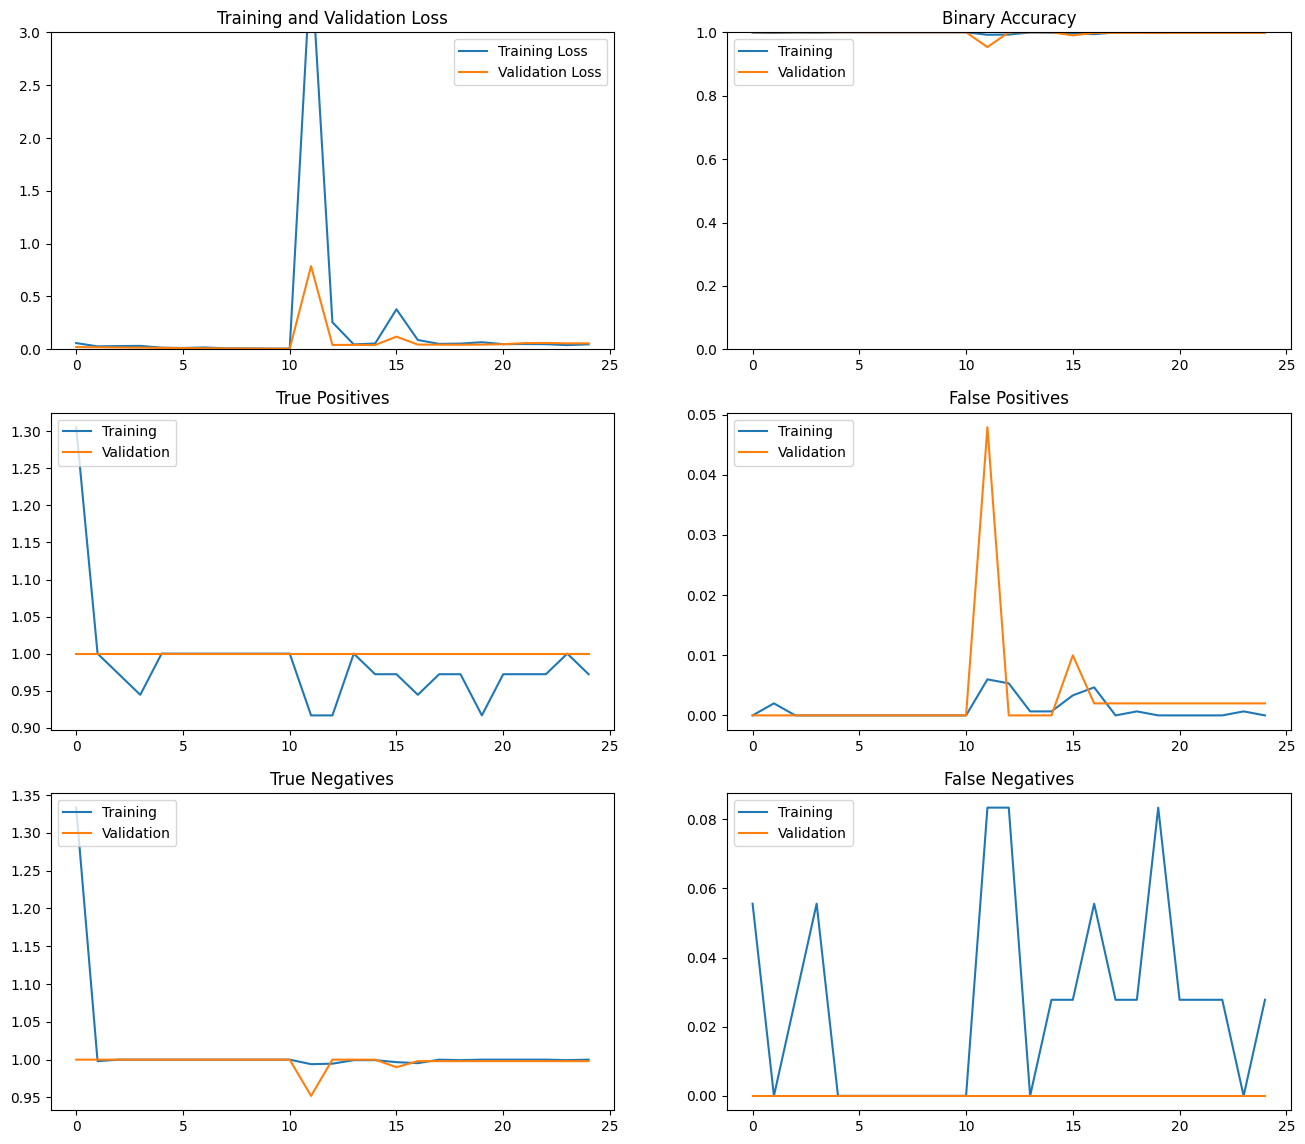

In [9]:
DisplayHistory(history, epochs, amounts)

### 1.0

In [10]:
def GenerateModelLayers10():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 20
model10, history, amounts = TrainScore(1.0, epochs=epochs, layerGenerator=GenerateModelLayers10)

(1539,)
Positive: 43; Train: 32; Valid: 11
Negative: 2010; Train: 1507; Valid: 503
Score_1.0_0
Epoch 1/20
49/49 [==============================] - 3s 46ms/step - loss: 2.9758 - binary_accuracy: 0.9352 - false_positives: 101.0000 - false_negatives: 32.0000 - true_positives: 13.0000 - true_negatives: 1907.0000 - val_loss: 1.2506 - val_binary_accuracy: 0.9786 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 503.0000
Epoch 2/20
49/49 [==============================] - 2s 43ms/step - loss: 1.2742 - binary_accuracy: 0.9773 - false_positives: 3.0000 - false_negatives: 32.0000 - true_positives: 0.0000e+00 - true_negatives: 1504.0000 - val_loss: 1.1033 - val_binary_accuracy: 0.9786 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 503.0000
Epoch 3/20
49/49 [==============================] - 2s 42ms/step - loss: 1.2529 - binary_accuracy: 0.9760 - false_posi

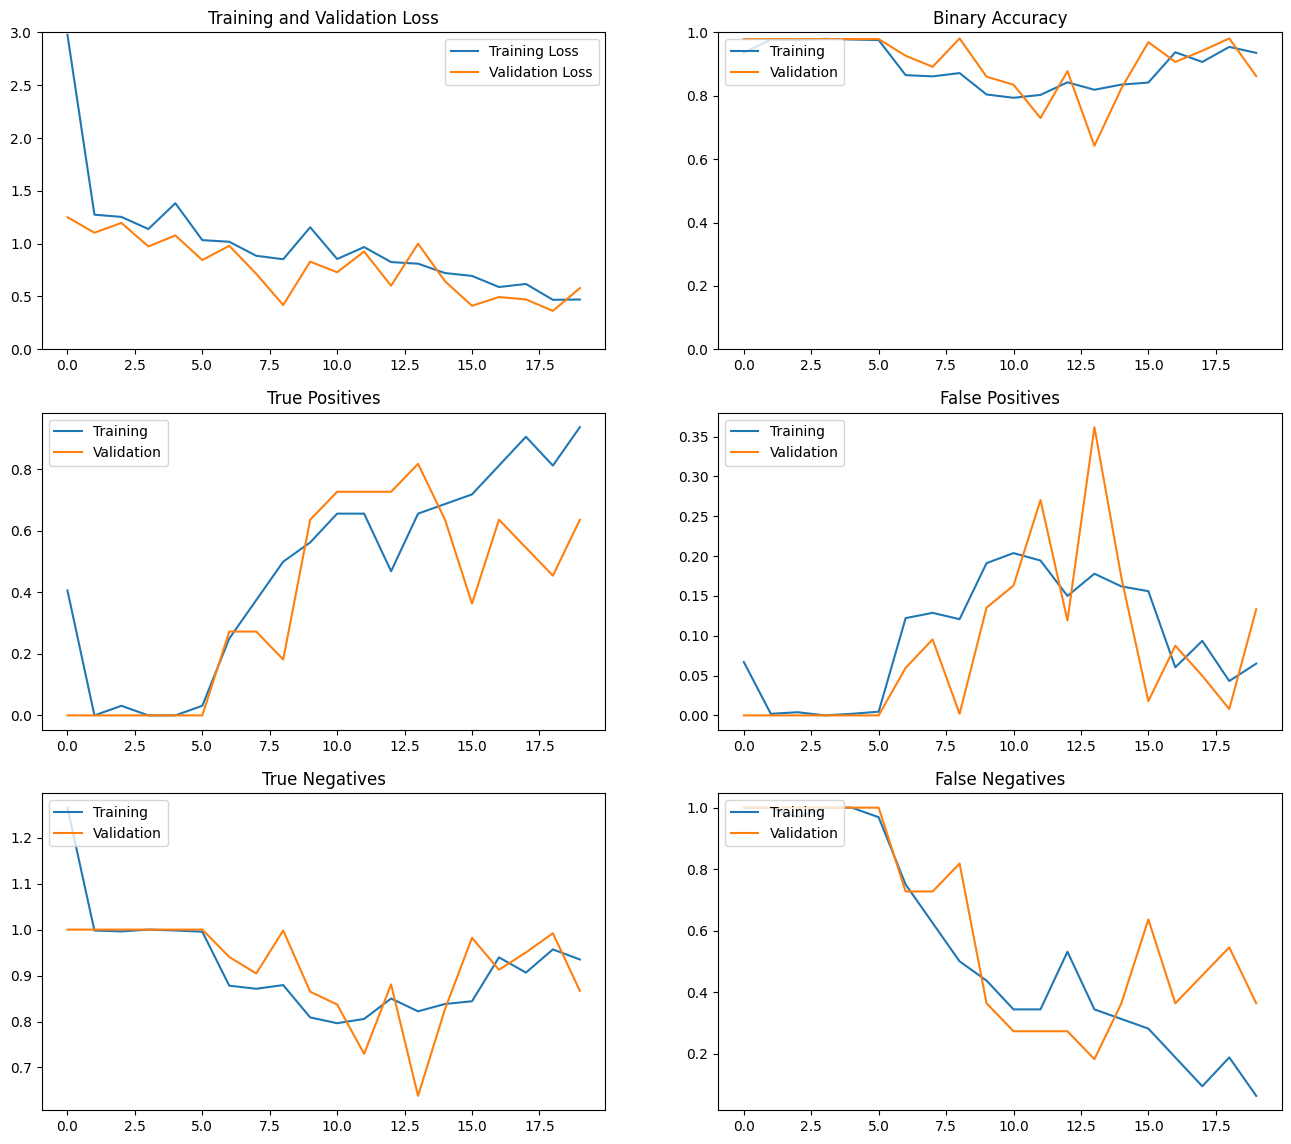

In [11]:
DisplayHistory(history, epochs, amounts)

### 1.5

In [12]:
def GenerateModelLayers15():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=24, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 20
model15, history, amounts = TrainScore(1.5, epochs=epochs, layerGenerator=GenerateModelLayers15)

(1539,)
Positive: 56; Train: 42; Valid: 14
Negative: 1997; Train: 1497; Valid: 500
Score_1.5_0
Epoch 1/20
49/49 [==============================] - 2s 40ms/step - loss: 1.8429 - binary_accuracy: 0.9187 - false_positives: 121.0000 - false_negatives: 46.0000 - true_positives: 7.0000 - true_negatives: 1879.0000 - val_loss: 1.5476 - val_binary_accuracy: 0.9728 - val_false_positives: 0.0000e+00 - val_false_negatives: 14.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 500.0000
Epoch 2/20
49/49 [==============================] - 2s 36ms/step - loss: 1.4130 - binary_accuracy: 0.9311 - false_positives: 67.0000 - false_negatives: 39.0000 - true_positives: 3.0000 - true_negatives: 1430.0000 - val_loss: 1.2733 - val_binary_accuracy: 0.9630 - val_false_positives: 6.0000 - val_false_negatives: 13.0000 - val_true_positives: 1.0000 - val_true_negatives: 494.0000
Epoch 3/20
49/49 [==============================] - 2s 37ms/step - loss: 1.0779 - binary_accuracy: 0.8928 - false_positives: 128.0

dict_keys(['loss', 'binary_accuracy', 'false_positives', 'false_negatives', 'true_positives', 'true_negatives', 'val_loss', 'val_binary_accuracy', 'val_false_positives', 'val_false_negatives', 'val_true_positives', 'val_true_negatives'])


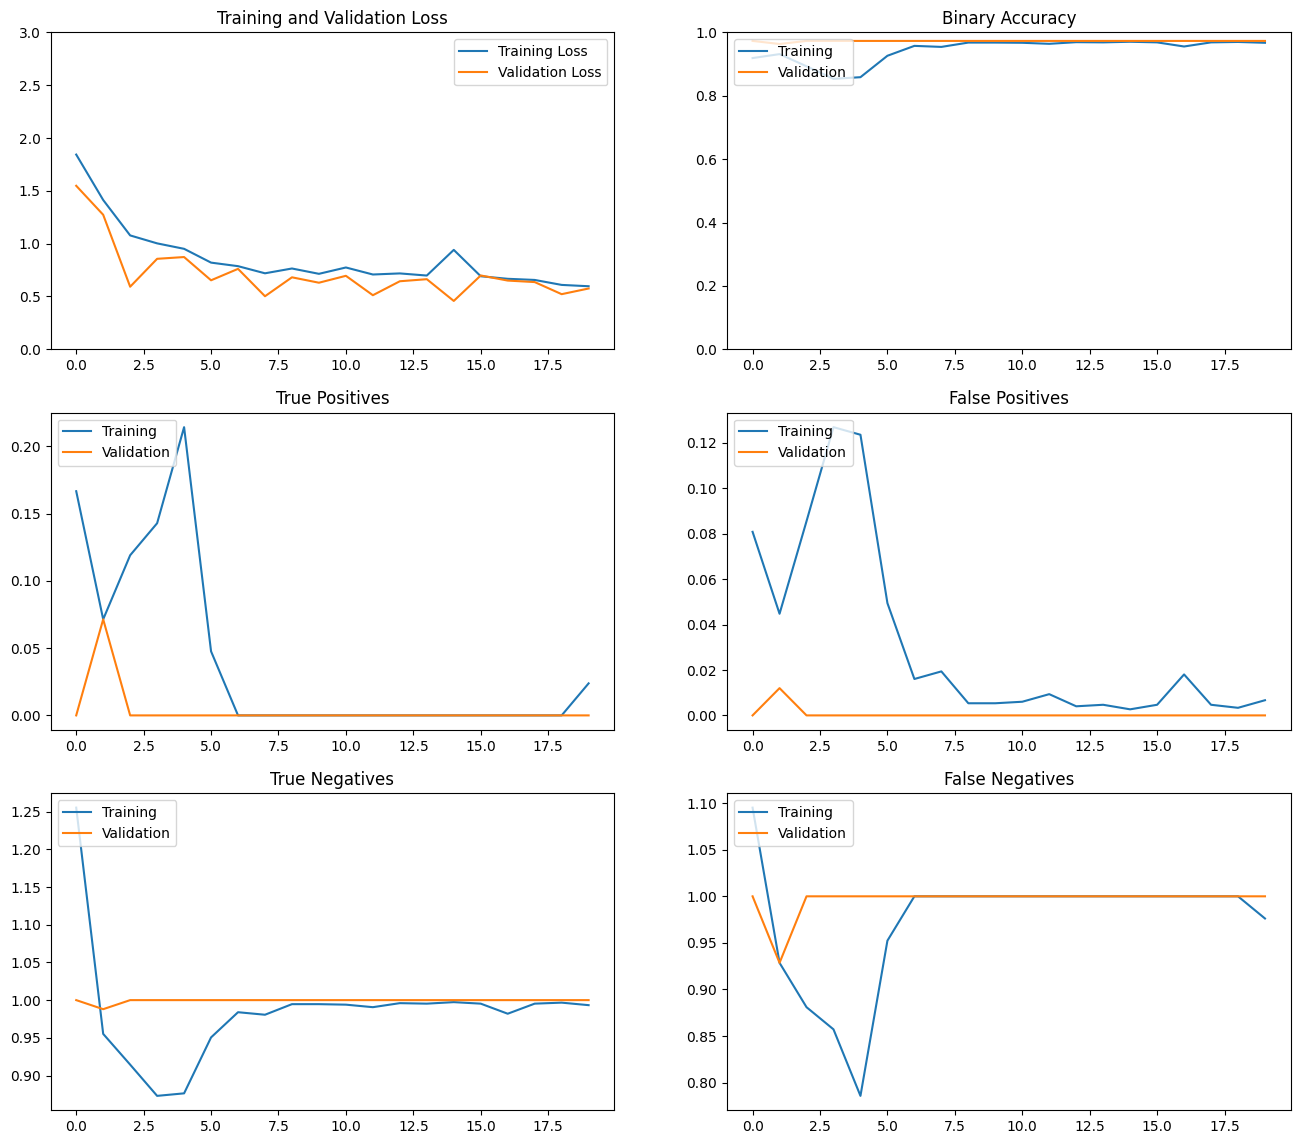

In [13]:
print(history.history.keys())
DisplayHistory(history, epochs, amounts)

### 2.0

In [14]:
def GenerateModelLayers20():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 25
model20, history, amounts = TrainScore(2.0, epochs=epochs, layerGenerator=GenerateModelLayers20)

(1539,)
Positive: 74; Train: 55; Valid: 19
Negative: 1979; Train: 1484; Valid: 495
Score_2.0_0
Epoch 1/25
49/49 [==============================] - 3s 44ms/step - loss: 1.4750 - binary_accuracy: 0.8169 - false_positives: 320.0000 - false_negatives: 56.0000 - true_positives: 13.0000 - true_negatives: 1664.0000 - val_loss: 0.8920 - val_binary_accuracy: 0.9630 - val_false_positives: 0.0000e+00 - val_false_negatives: 19.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 495.0000
Epoch 2/25
49/49 [==============================] - 2s 40ms/step - loss: 0.9951 - binary_accuracy: 0.9610 - false_positives: 5.0000 - false_negatives: 55.0000 - true_positives: 0.0000e+00 - true_negatives: 1479.0000 - val_loss: 0.7909 - val_binary_accuracy: 0.9494 - val_false_positives: 7.0000 - val_false_negatives: 19.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 488.0000
Epoch 3/25
49/49 [==============================] - 2s 41ms/step - loss: 0.8582 - binary_accuracy: 0.8298 - false_positive

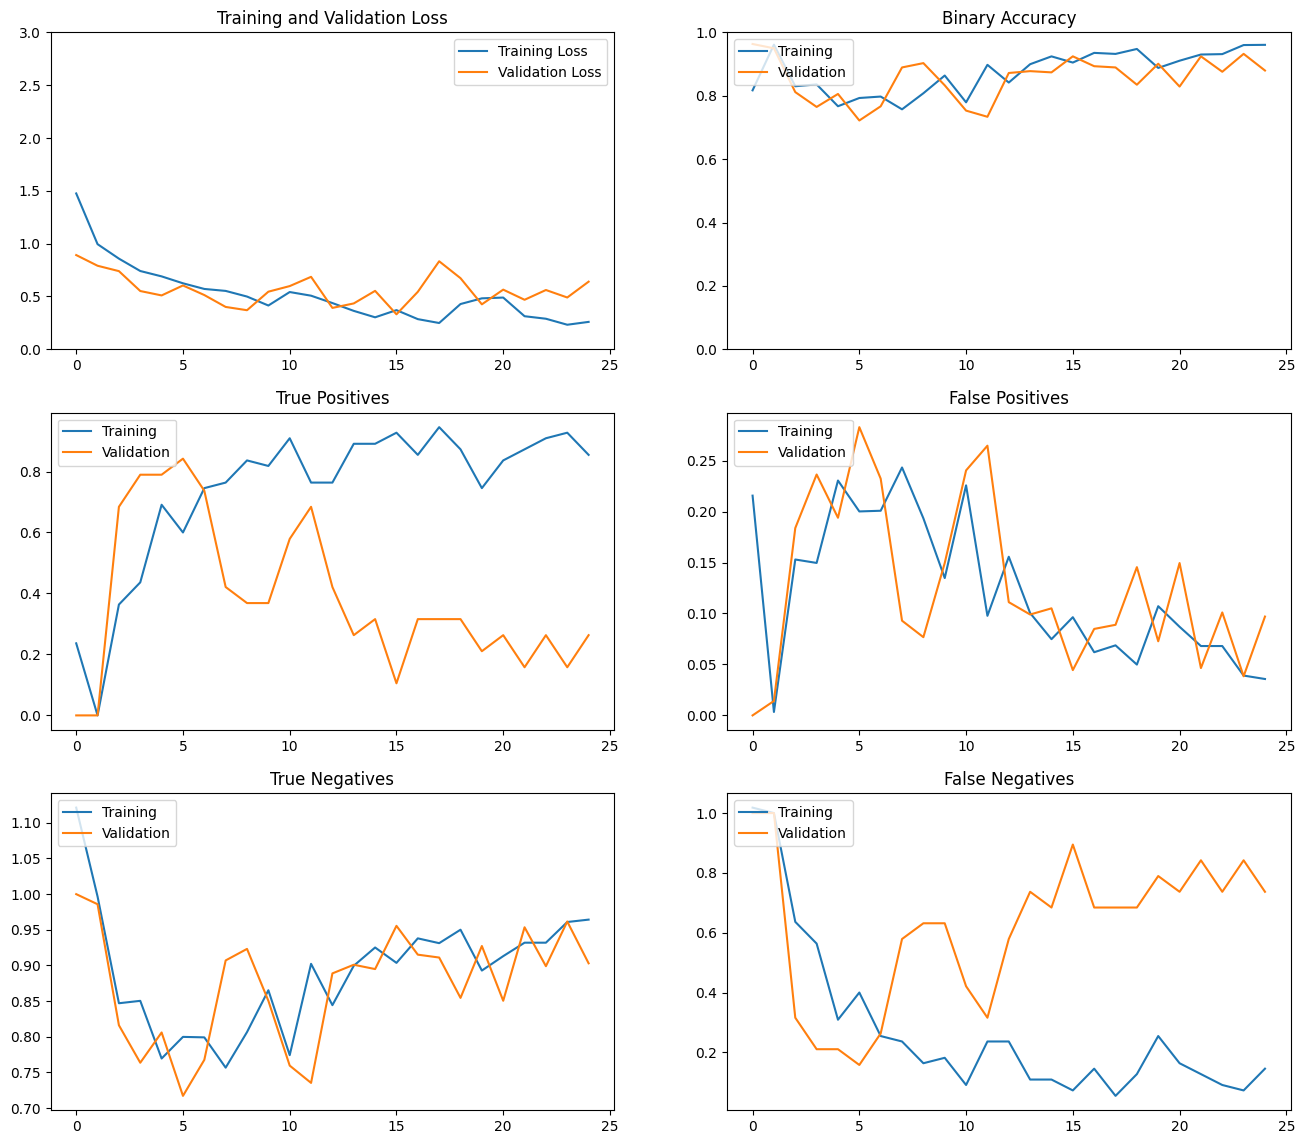

In [15]:
DisplayHistory(history, epochs, amounts)

### 2.5

In [16]:
def GenerateModelLayers25():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=6, 
                                    kernel_size = (2,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 20
model25, history, amounts = TrainScore(2.5, epochs=epochs, layerGenerator=GenerateModelLayers25)

(1539,)
Positive: 161; Train: 120; Valid: 41
Negative: 1892; Train: 1419; Valid: 473
Score_2.5_0
Epoch 1/20
49/49 [==============================] - 2s 37ms/step - loss: 1.4902 - binary_accuracy: 0.8412 - false_positives: 213.0000 - false_negatives: 113.0000 - true_positives: 26.0000 - true_negatives: 1701.0000 - val_loss: 1.1048 - val_binary_accuracy: 0.9125 - val_false_positives: 5.0000 - val_false_negatives: 40.0000 - val_true_positives: 1.0000 - val_true_negatives: 468.0000
Epoch 2/20
49/49 [==============================] - 2s 34ms/step - loss: 1.0238 - binary_accuracy: 0.7921 - false_positives: 260.0000 - false_negatives: 60.0000 - true_positives: 60.0000 - true_negatives: 1159.0000 - val_loss: 0.9578 - val_binary_accuracy: 0.7218 - val_false_positives: 125.0000 - val_false_negatives: 18.0000 - val_true_positives: 23.0000 - val_true_negatives: 348.0000
Epoch 3/20
49/49 [==============================] - 2s 35ms/step - loss: 0.8453 - binary_accuracy: 0.8233 - false_positives: 205.

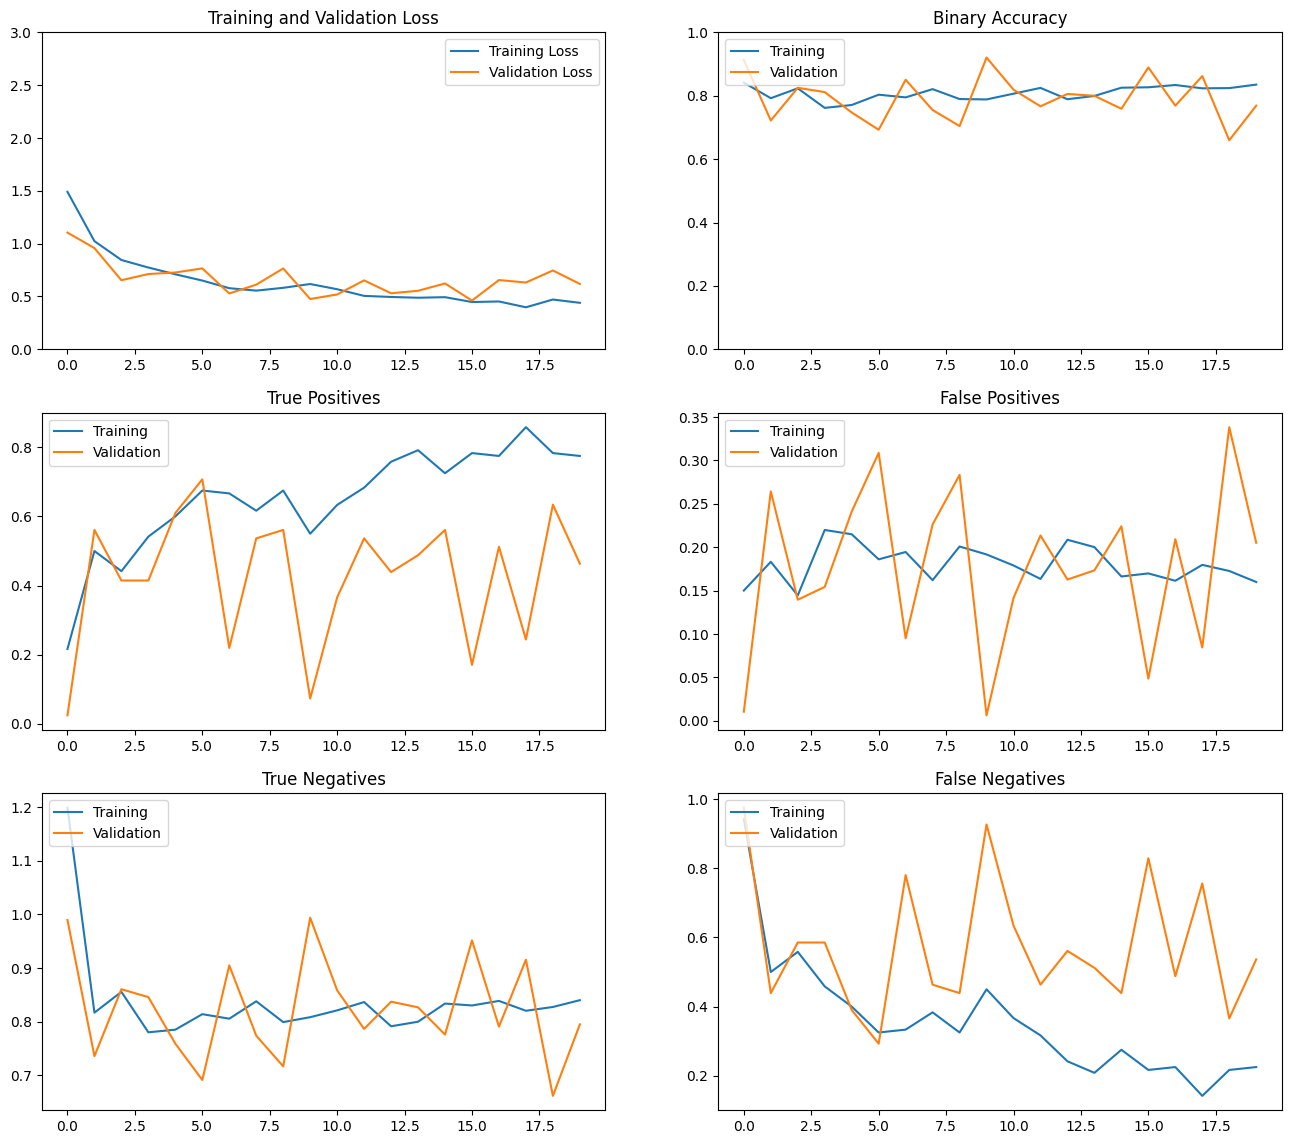

In [17]:
DisplayHistory(history, epochs, amounts)

### 3.0

In [18]:
def GenerateModelLayers30():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=8, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    # layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    # layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=96, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output
epochs = 20
model30, history, amounts = TrainScore(3.0, epochs=epochs, layerGenerator= GenerateModelLayers30)

(1539,)
Positive: 269; Train: 201; Valid: 68
Negative: 1784; Train: 1338; Valid: 446
Score_3.0_0
Epoch 1/20
49/49 [==============================] - 3s 40ms/step - loss: 1.4059 - binary_accuracy: 0.8183 - false_positives: 150.0000 - false_negatives: 223.0000 - true_positives: 19.0000 - true_negatives: 1661.0000 - val_loss: 1.1219 - val_binary_accuracy: 0.8677 - val_false_positives: 0.0000e+00 - val_false_negatives: 68.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 446.0000
Epoch 2/20
49/49 [==============================] - 2s 36ms/step - loss: 0.9940 - binary_accuracy: 0.8285 - false_positives: 69.0000 - false_negatives: 195.0000 - true_positives: 6.0000 - true_negatives: 1269.0000 - val_loss: 0.8467 - val_binary_accuracy: 0.8677 - val_false_positives: 0.0000e+00 - val_false_negatives: 68.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 446.0000
Epoch 3/20
49/49 [==============================] - 2s 37ms/step - loss: 0.7944 - binary_accuracy: 0.8545 - false_pos

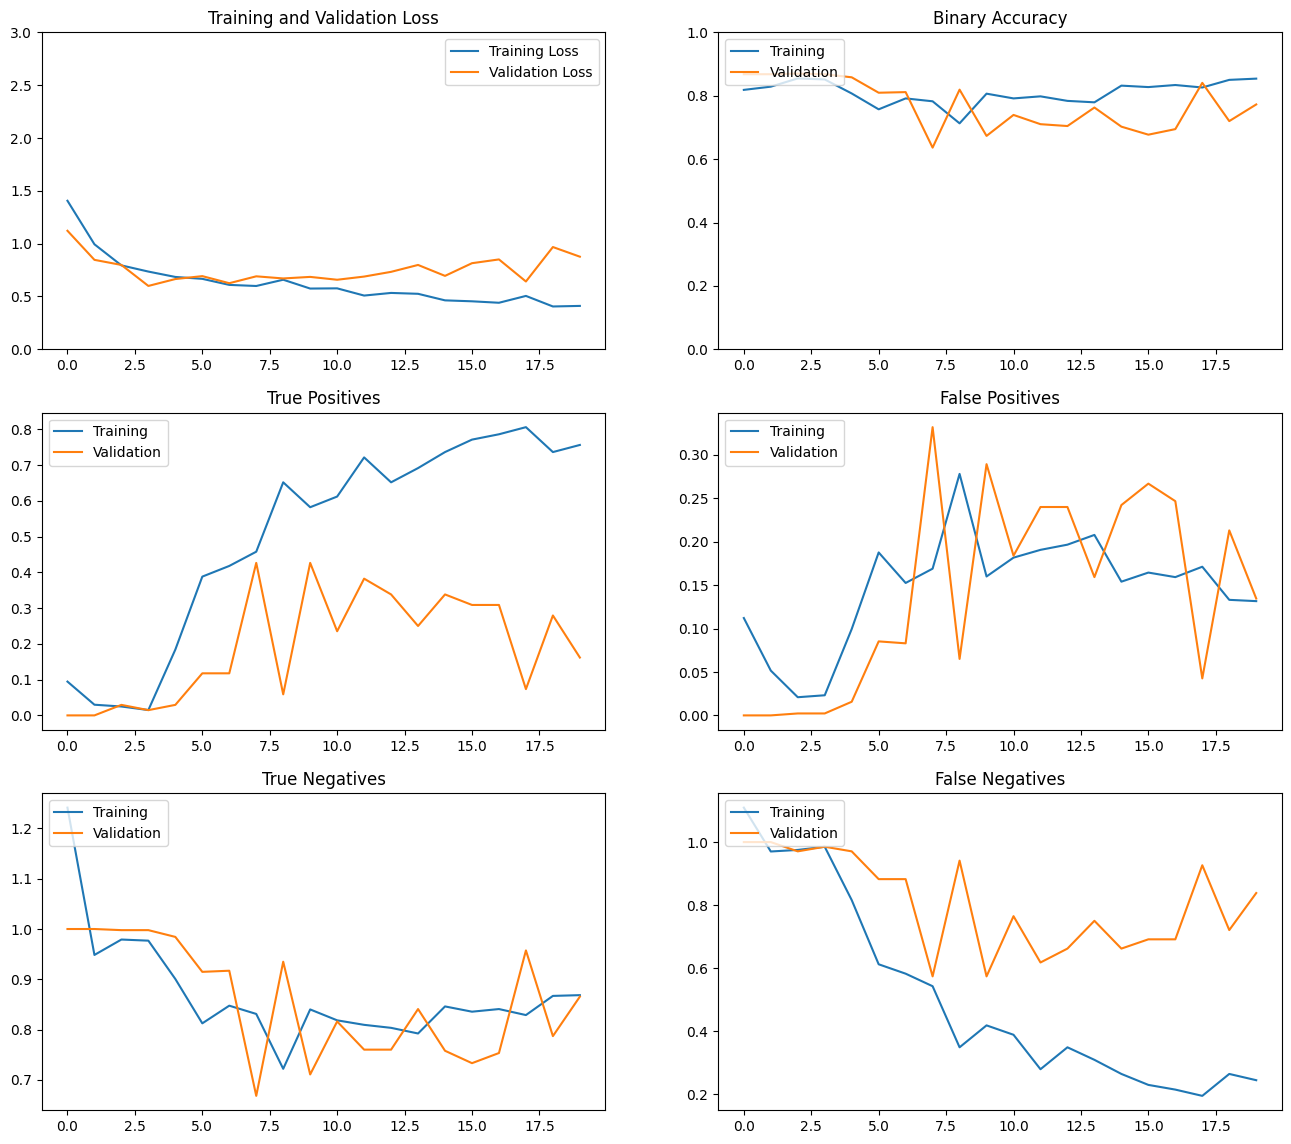

In [19]:
DisplayHistory(history, epochs, amounts)

### 3.5

In [20]:
def GenerateModelLayers35():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)


    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=72, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=36, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output


epochs = 20
model35, history, amounts = TrainScore(3.5, epochs=epochs, layerGenerator=GenerateModelLayers35)

(1539,)
Positive: 389; Train: 291; Valid: 98
Negative: 1664; Train: 1248; Valid: 416
Score_3.5_0
Epoch 1/20
49/49 [==============================] - 2s 39ms/step - loss: 1.1282 - binary_accuracy: 0.7589 - false_positives: 166.0000 - false_negatives: 329.0000 - true_positives: 30.0000 - true_negatives: 1528.0000 - val_loss: 0.8384 - val_binary_accuracy: 0.8093 - val_false_positives: 0.0000e+00 - val_false_negatives: 98.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 416.0000
Epoch 2/20
49/49 [==============================] - 2s 36ms/step - loss: 0.8363 - binary_accuracy: 0.7706 - false_positives: 80.0000 - false_negatives: 273.0000 - true_positives: 18.0000 - true_negatives: 1168.0000 - val_loss: 0.7873 - val_binary_accuracy: 0.8093 - val_false_positives: 0.0000e+00 - val_false_negatives: 98.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 416.0000
Epoch 3/20
49/49 [==============================] - 2s 36ms/step - loss: 0.7747 - binary_accuracy: 0.7927 - false_po

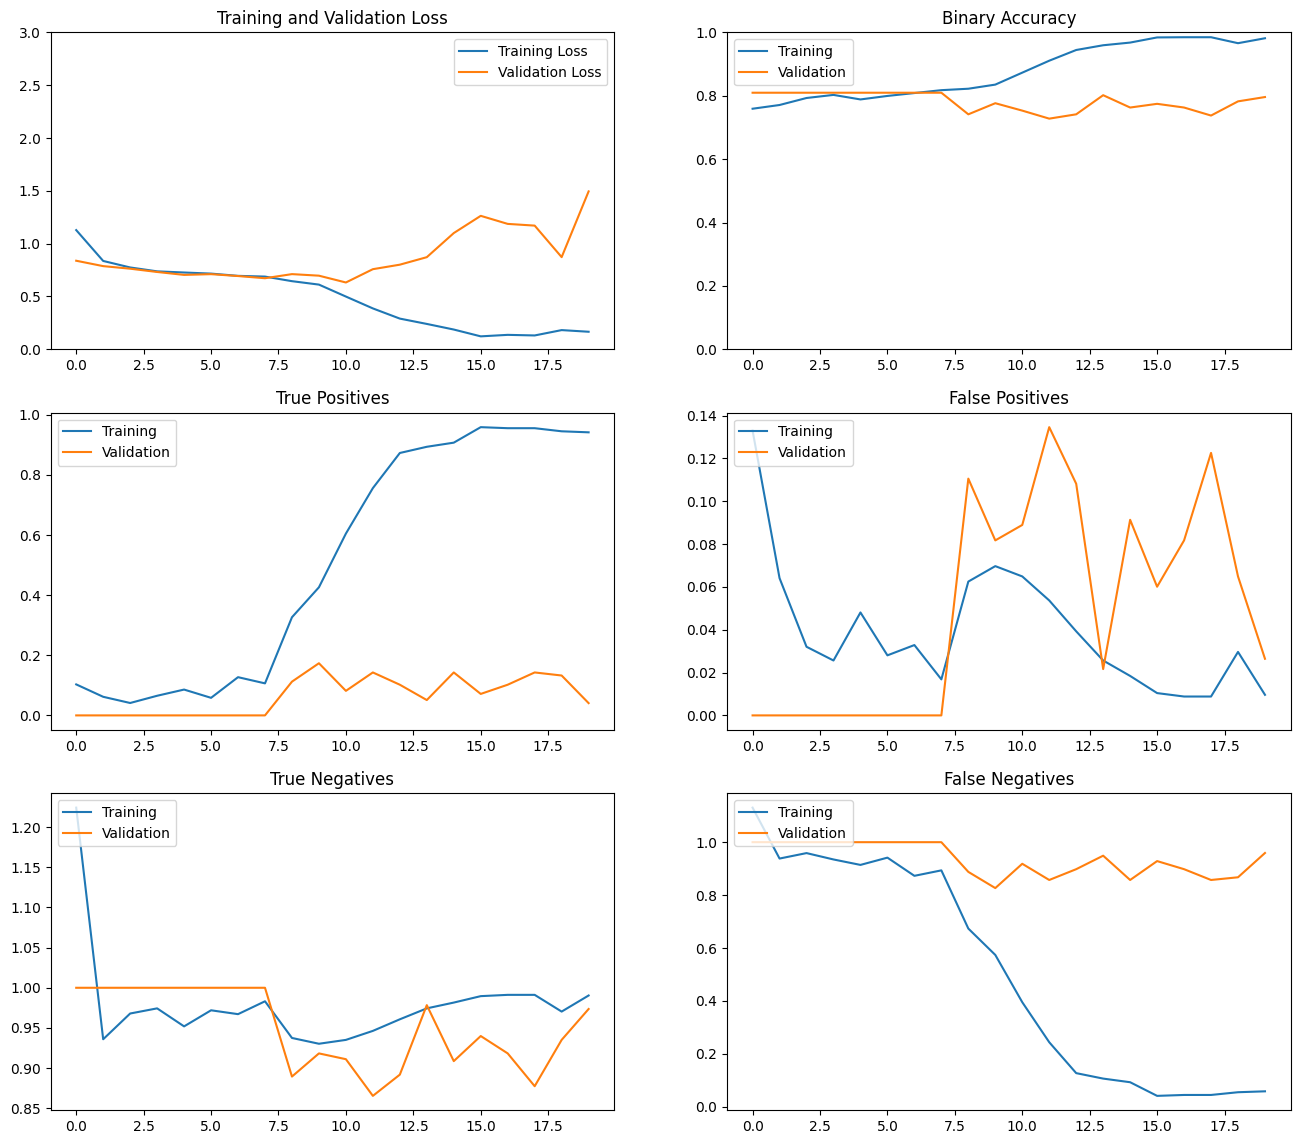

In [21]:
DisplayHistory(history, epochs, amounts)

### 4.0

In [22]:
def GenerateModelLayers40():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=32, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=24, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=144, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=36, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 50
model40, history, amounts = TrainScore(4.0, epochs=epochs, layerGenerator=GenerateModelLayers40)

(1539,)
Positive: 400; Train: 300; Valid: 100
Negative: 1653; Train: 1239; Valid: 414
Score_4.0_0
Epoch 1/50
49/49 [==============================] - 2s 20ms/step - loss: 1.4019 - binary_accuracy: 0.7725 - false_positives: 90.0000 - false_negatives: 377.0000 - true_positives: 21.0000 - true_negatives: 1565.0000 - val_loss: 1.1901 - val_binary_accuracy: 0.7938 - val_false_positives: 6.0000 - val_false_negatives: 100.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 408.0000
Epoch 2/50
49/49 [==============================] - 1s 16ms/step - loss: 1.0037 - binary_accuracy: 0.7771 - false_positives: 52.0000 - false_negatives: 291.0000 - true_positives: 9.0000 - true_negatives: 1187.0000 - val_loss: 0.8977 - val_binary_accuracy: 0.8054 - val_false_positives: 0.0000e+00 - val_false_negatives: 100.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 414.0000
Epoch 3/50
49/49 [==============================] - 1s 17ms/step - loss: 0.8209 - binary_accuracy: 0.7960 - false_posit

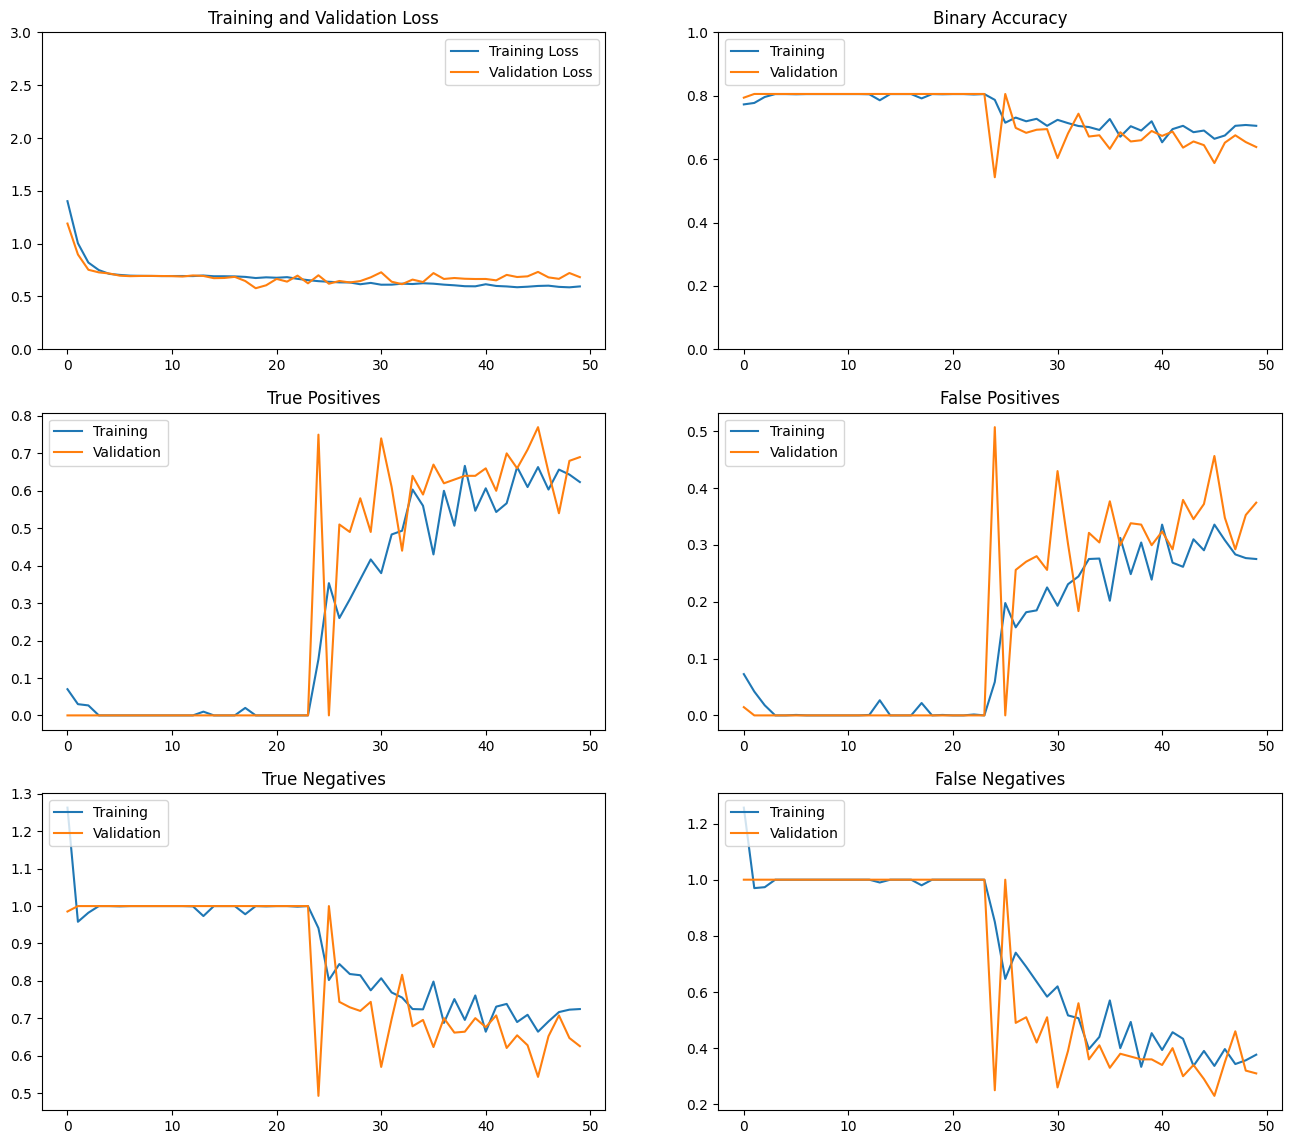

In [23]:
DisplayHistory(history, epochs, amounts)

### 4.5

In [24]:
def GenerateModelLayers45():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=32, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=24, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=144, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=36, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 25
model45, history, amounts = TrainScore(4.5, epochs=epochs, layerGenerator=GenerateModelLayers45)

(1539,)
Positive: 322; Train: 241; Valid: 81
Negative: 1731; Train: 1298; Valid: 433
Score_4.5_0
Epoch 1/25
49/49 [==============================] - 2s 20ms/step - loss: 1.4440 - binary_accuracy: 0.7321 - false_positives: 314.0000 - false_negatives: 236.0000 - true_positives: 105.0000 - true_negatives: 1398.0000 - val_loss: 1.1887 - val_binary_accuracy: 0.8424 - val_false_positives: 0.0000e+00 - val_false_negatives: 81.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 433.0000
Epoch 2/25
49/49 [==============================] - 1s 16ms/step - loss: 1.0385 - binary_accuracy: 0.7830 - false_positives: 131.0000 - false_negatives: 203.0000 - true_positives: 38.0000 - true_negatives: 1167.0000 - val_loss: 0.9002 - val_binary_accuracy: 0.8424 - val_false_positives: 0.0000e+00 - val_false_negatives: 81.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 433.0000
Epoch 3/25
49/49 [==============================] - 1s 17ms/step - loss: 0.8368 - binary_accuracy: 0.8129 - false_

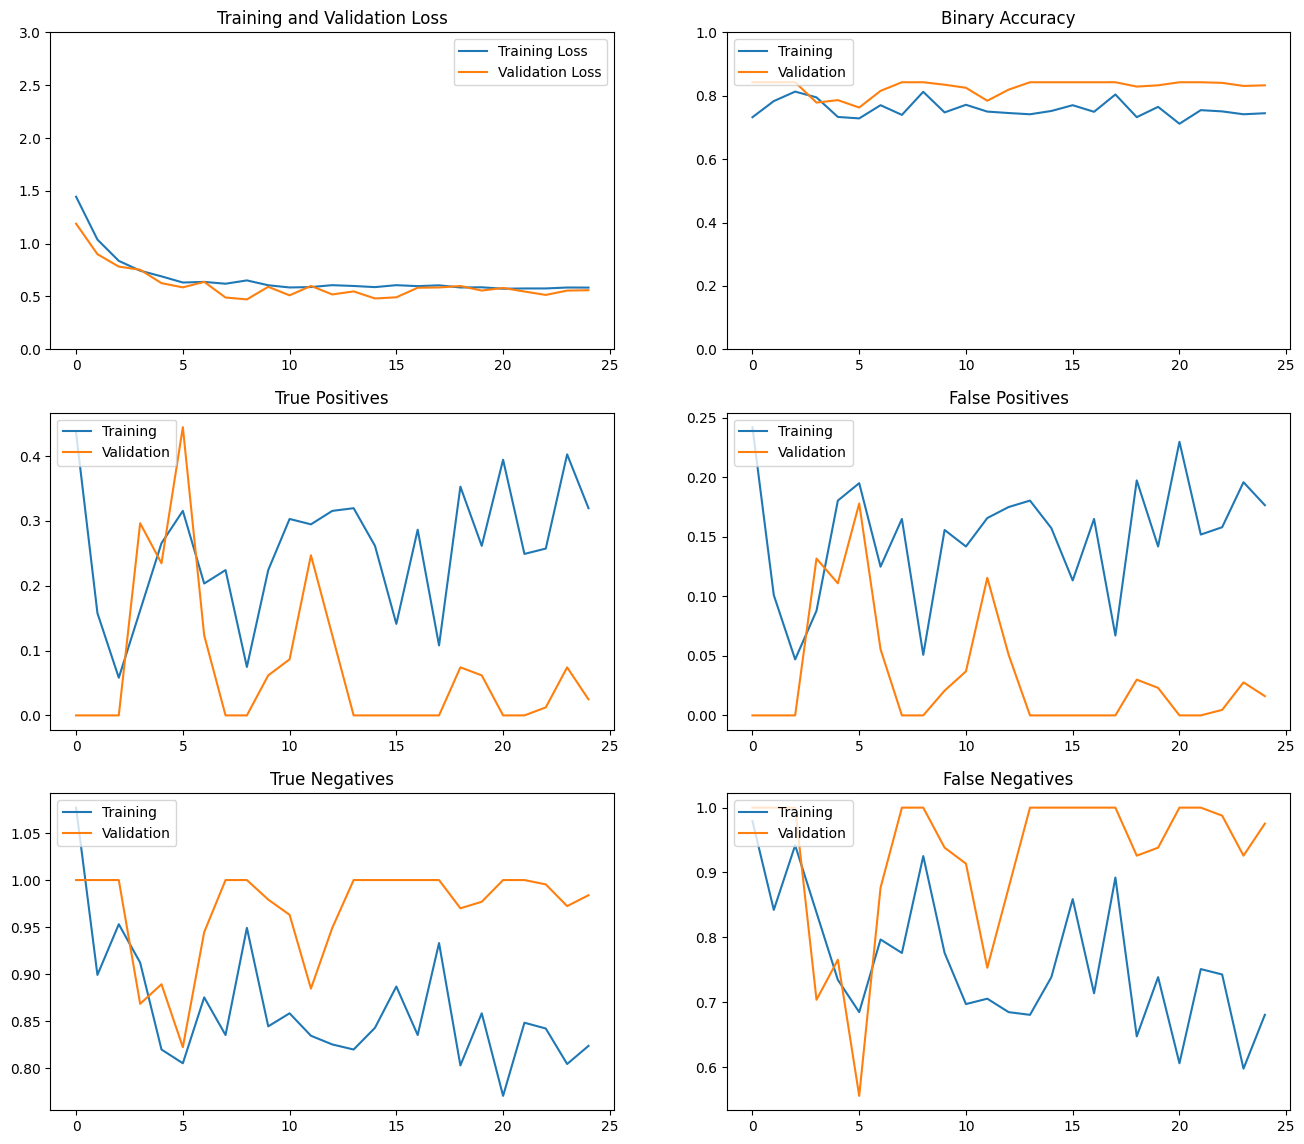

In [25]:
DisplayHistory(history, epochs, amounts)

### 5.0

In [26]:
def GenerateModelLayers50():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=32, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=24, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=64, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=36, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 20
model50, history, amounts = TrainScore(5.0, epochs=epochs, num_models=3, layerGenerator=GenerateModelLayers50)

(1539,)
Positive: 144; Train: 108; Valid: 36
Negative: 1909; Train: 1431; Valid: 478
Score_5.0_0
Epoch 1/20
49/49 [==============================] - 1s 19ms/step - loss: 1.6057 - binary_accuracy: 0.7092 - false_positives: 458.0000 - false_negatives: 139.0000 - true_positives: 50.0000 - true_negatives: 1406.0000 - val_loss: 1.3454 - val_binary_accuracy: 0.9125 - val_false_positives: 10.0000 - val_false_negatives: 35.0000 - val_true_positives: 1.0000 - val_true_negatives: 468.0000
Epoch 2/20
49/49 [==============================] - 1s 15ms/step - loss: 1.2642 - binary_accuracy: 0.7849 - false_positives: 267.0000 - false_negatives: 64.0000 - true_positives: 44.0000 - true_negatives: 1164.0000 - val_loss: 1.0400 - val_binary_accuracy: 0.7763 - val_false_positives: 96.0000 - val_false_negatives: 19.0000 - val_true_positives: 17.0000 - val_true_negatives: 382.0000
Epoch 3/20
49/49 [==============================] - 1s 16ms/step - loss: 0.9782 - binary_accuracy: 0.7544 - false_positives: 323.

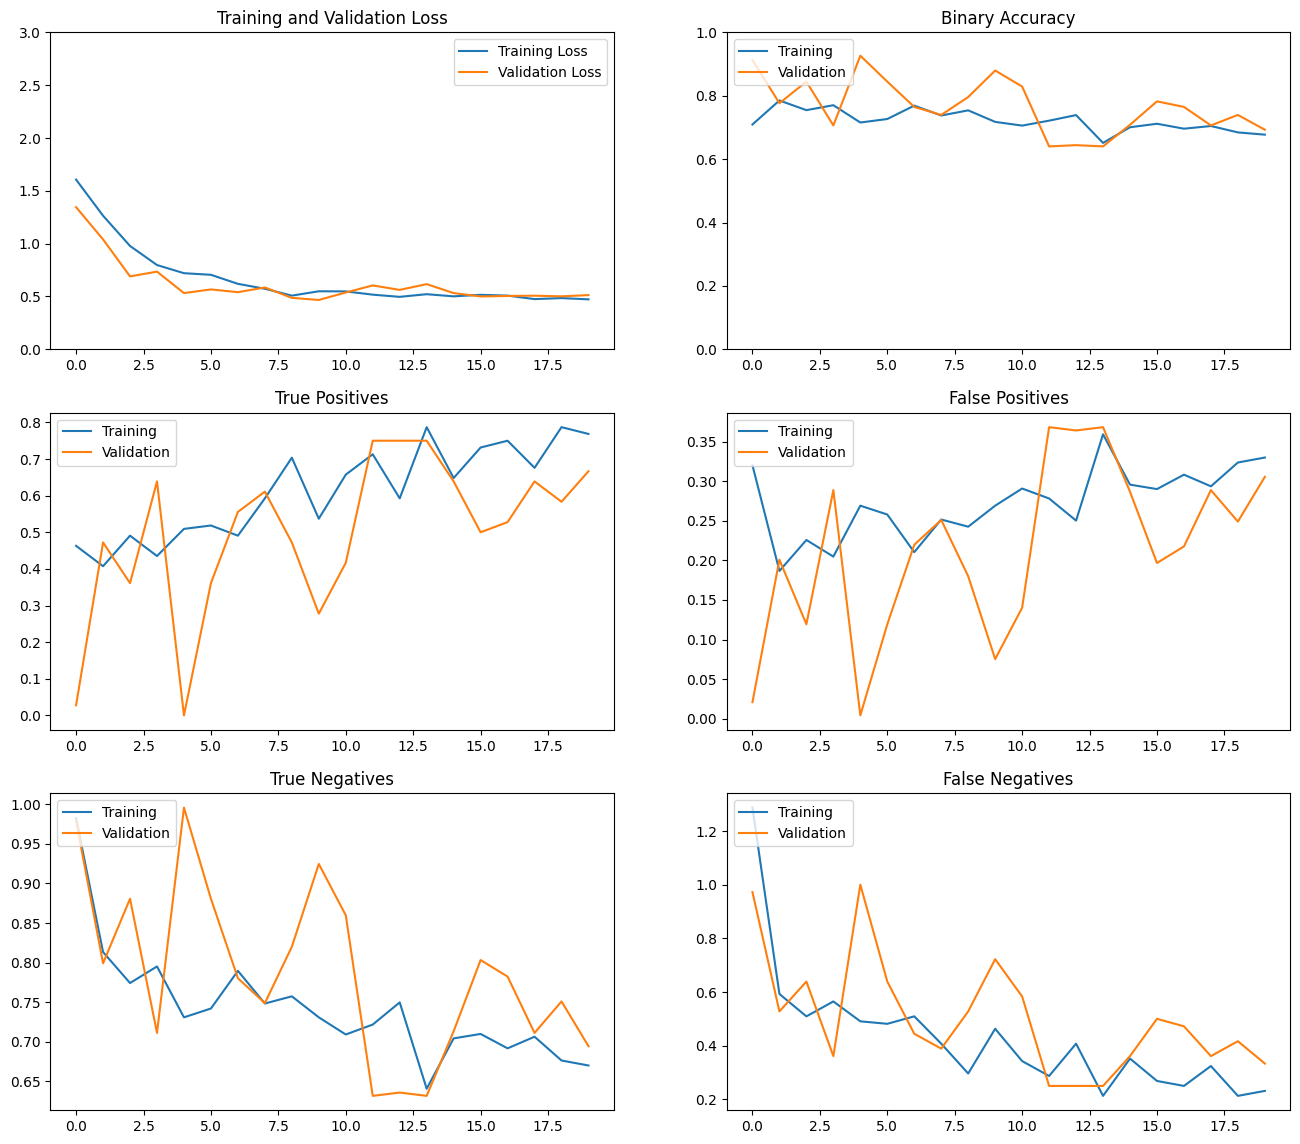

In [27]:
DisplayHistory(history, epochs, amounts)

### 5.5

In [28]:
def GenerateModelLayers55():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=32, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=24, 
                                    kernel_size = (2,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=256, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=256, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=144, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=36, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 25
model55, history, amounts = TrainScore(5.5, epochs=epochs, layerGenerator=GenerateModelLayers55)

(1539,)
Positive: 103; Train: 77; Valid: 26
Negative: 1950; Train: 1462; Valid: 488
Score_5.5_0
Epoch 1/25
49/49 [==============================] - 2s 21ms/step - loss: 1.6766 - binary_accuracy: 0.7389 - false_positives: 468.0000 - false_negatives: 68.0000 - true_positives: 45.0000 - true_negatives: 1472.0000 - val_loss: 1.4378 - val_binary_accuracy: 0.8113 - val_false_positives: 84.0000 - val_false_negatives: 13.0000 - val_true_positives: 13.0000 - val_true_negatives: 404.0000
Epoch 2/25
49/49 [==============================] - 1s 16ms/step - loss: 1.1728 - binary_accuracy: 0.7810 - false_positives: 300.0000 - false_negatives: 37.0000 - true_positives: 40.0000 - true_negatives: 1162.0000 - val_loss: 0.8658 - val_binary_accuracy: 0.8521 - val_false_positives: 59.0000 - val_false_negatives: 17.0000 - val_true_positives: 9.0000 - val_true_negatives: 429.0000
Epoch 3/25
49/49 [==============================] - 1s 16ms/step - loss: 0.9815 - binary_accuracy: 0.7693 - false_positives: 328.00

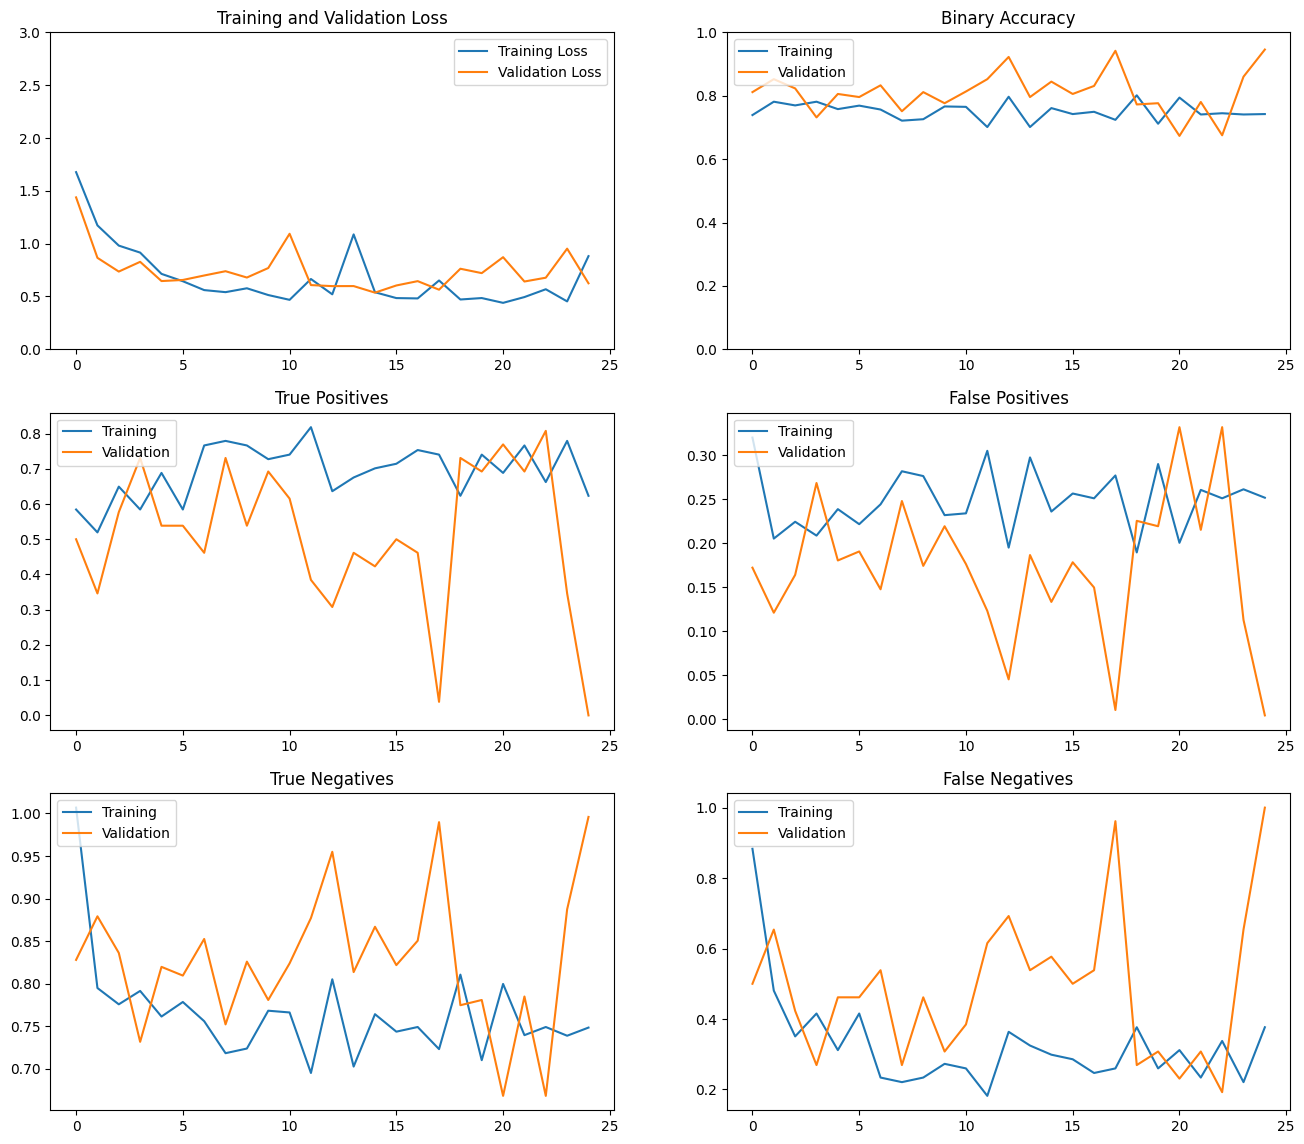

In [29]:
DisplayHistory(history, epochs, amounts)

### 6.0

In [30]:
def GenerateModelLayers60():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=160, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=40, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=8, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=128, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=24, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=12, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=80, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

epochs = 40
model60, history, amounts = TrainScore(6.0, epochs=epochs, layerGenerator = GenerateModelLayers60)

(1539,)
Positive: 43; Train: 32; Valid: 11
Negative: 2010; Train: 1507; Valid: 503
Score_6.0_0
Epoch 1/40
49/49 [==============================] - 2s 39ms/step - loss: 2.0806 - binary_accuracy: 0.8300 - false_positives: 314.0000 - false_negatives: 35.0000 - true_positives: 23.0000 - true_negatives: 1681.0000 - val_loss: 1.5602 - val_binary_accuracy: 0.9786 - val_false_positives: 0.0000e+00 - val_false_negatives: 11.0000 - val_true_positives: 0.0000e+00 - val_true_negatives: 503.0000
Epoch 2/40
49/49 [==============================] - 2s 35ms/step - loss: 1.4521 - binary_accuracy: 0.9162 - false_positives: 106.0000 - false_negatives: 23.0000 - true_positives: 9.0000 - true_negatives: 1401.0000 - val_loss: 0.9664 - val_binary_accuracy: 0.8735 - val_false_positives: 62.0000 - val_false_negatives: 3.0000 - val_true_positives: 8.0000 - val_true_negatives: 441.0000
Epoch 3/40
49/49 [==============================] - 2s 36ms/step - loss: 1.2330 - binary_accuracy: 0.8525 - false_positives: 207

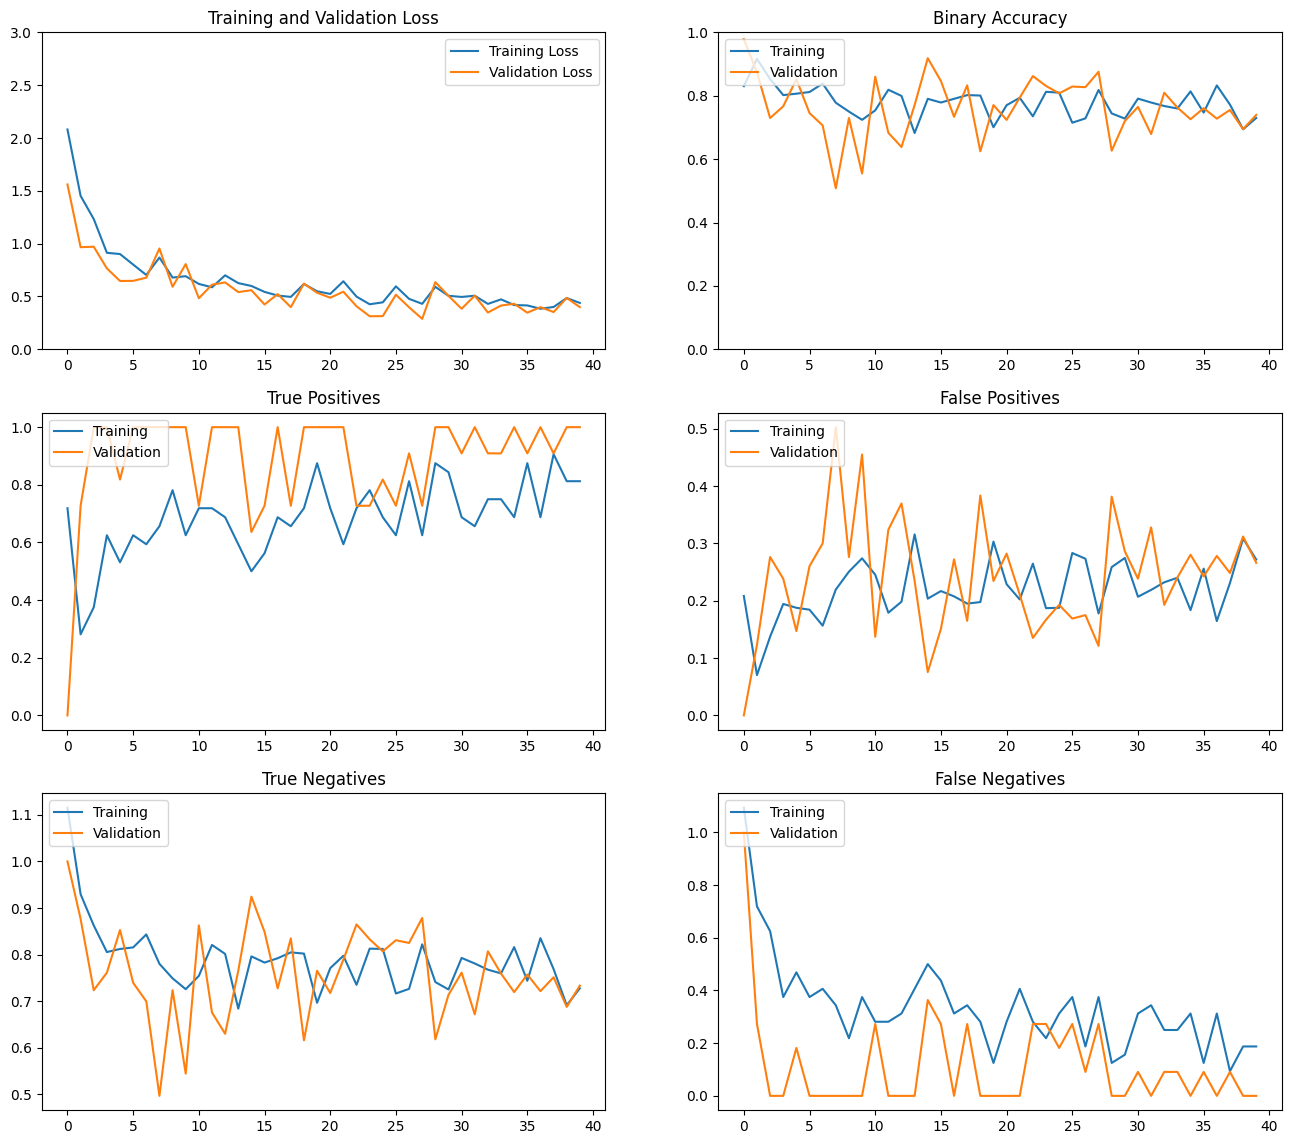

In [31]:
DisplayHistory(history, epochs, amounts)

## Model Combination

In [32]:
AllModels = {
    0.5: model05,
    1.0: model10,
    1.5: model15,
    2.0: model20,
    2.5: model25,
    3.0: model30,
    3.5: model35,
    4.0: model40,
    4.5: model45,
    5.0: model50,
    5.5: model55,
    6.0: model60
}

### Data Preperation

In [33]:
TOTAL_TRAIN = 0

for score_index, score in enumerate(score_labels):
    TOTAL_TRAIN += train_x_1[score].shape[0]

SHAPE_INPUT_XP = (TOTAL_TRAIN, 12)

com_train_x_1 = np.zeros(shape=(TOTAL_TRAIN, train_x_1[0.5].shape[1], train_x_1[0.5].shape[2]))
com_train_x_2 = np.zeros(shape=(TOTAL_TRAIN, train_x_2[0.5].shape[1]))
com_train_x_P = np.zeros(shape=SHAPE_INPUT_XP)
com_train_y = np.zeros(shape=(TOTAL_TRAIN))


com_index = 0
for score_index, score in enumerate(score_labels):
    print(score)
    for index, x in enumerate(train_x_1[score]):
        com_train_x_1[com_index] = train_x_1[score][index]
        com_train_x_2[com_index] = train_x_2[score][index]
        com_train_y[com_index] = score

        for score_index_2, score_2 in enumerate(score_labels):
            prediction = AllModels[score_2].predict(
                x=[np.array([train_x_1[score][index]]), np.array([train_x_2[score][index]])],
                verbose=0
                )
            com_train_x_P[com_index][score_index_2] = prediction
        
        com_index += 1

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0


In [34]:
print(f"Com_Train_x1: Shape - {com_train_x_1.shape}, Ex: {com_train_x_1[0]}")
print(f"Com_Train_x2: Shape - {com_train_x_2.shape}, Ex: {com_train_x_2[0]}")
print(f"Com_Train_xP: Shape - {com_train_x_P.shape}, Ex: {com_train_x_P[0]}")
print(f"Com_Train_y:  Shape - {com_train_y.shape}, Ex: {com_train_y[0]}")

Com_Train_x1: Shape - (2053, 1800, 14), Ex: [[1.25000000e-03 3.42465753e-03 6.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.25000000e-03 3.42465753e-03 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.25000000e-03 3.42465753e-03 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 ...
 [1.25000000e-03 3.42465753e-03 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.25000000e-03 3.42465753e-03 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.25000000e-03 3.42465753e-03 4.00000000e+00 ... 5.00000000e+00
  2.00000000e+00 3.00000000e+00]]
Com_Train_x2: Shape - (2053, 54), Ex: [2.51250000e-01 2.29500000e-01 1.79666667e-02 2.28000000e-01
 2.01500000e-01 1.80000000e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.20000000e-01 2.97000000e-01
 6.80000000e-02 0.00000000e+00 8.02368421e-01 2.19528000e-01
 3.92232488e-01 4.86422151e-02 5.37309708e+00 7.35039680e+00
 4.78917404e-

### Layer Generation

In [42]:
def GenerateModelLayersFinalModel():
    input_shape_1 = SHAPE_INPUT_X1
    input_shape_2 = SHAPE_INPUT_X2
    input_shape_3 = SHAPE_INPUT_XP[1]

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)
    input_3 = tf.keras.Input(shape=input_shape_3, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=8, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=64, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(input_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=2, activation='relu')(layers_3)
    model_3 = tf.keras.models.Model(inputs = input_3, outputs=layers_3)

    layers_4 = tf.keras.layers.Dense(units=16, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output, model_3.output]))
    layers_4 = tf.keras.layers.Dropout(0.4)(layers_4)
    layers_4 = tf.keras.layers.Dense(units=16, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output, model_3.output]))
    layers_4 = tf.keras.layers.Dropout(0.4)(layers_4)
    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.linear)(layers_4)
    return model_1.input, model_2.input, model_3.input, layers_Output

loss_final = [tf.keras.losses.MeanAbsoluteError()]
metrics_final = [tf.keras.metrics.RootMeanSquaredError()]

Split_1_Input, Split_2_Input, Split_3_Input, Split_Output = GenerateModelLayersFinalModel()
modelCom = tf.keras.models.Model(inputs=[Split_1_Input, Split_2_Input, Split_3_Input], outputs=Split_Output, name="Final")
modelCom.compile(optimizer='adam', loss=loss_final, metrics=metrics_final)
modelCom.summary()

del modelCom
del Split_1_Input
del Split_2_Input
del Split_3_Input
del Split_Output

Model: "Final"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 1800, 14)]           0         []                            
                                                                                                  
 normalization_30 (Normaliz  (None, 1800, 14)             29        ['input_33[0][0]']            
 ation)                                                                                           
                                                                                                  
 conv1d_40 (Conv1D)          (None, 900, 80)              4560      ['normalization_30[0][0]']    
                                                                                                  
 input_34 (InputLayer)       [(None, 54)]                 0         []                        

### Training

In [43]:
num_models = 3
epochs = 100
Final_1_Input, Final_2_Input, Final_3_Input, Final_Output = GenerateModelLayersFinalModel()
FinalModels = [tf.keras.models.Model(inputs=[Final_1_Input, Final_2_Input, Final_3_Input], outputs=Final_Output, name=f"Final_Model_{x}") for x in range(num_models)]

best_loss_final = 10000
best_model_final = None
best_history_final = None

for model in FinalModels:
    print(f"{model.name}")
    model.compile(optimizer='adam', loss=loss_final, metrics=metrics_final)
    history_final = model.fit(x=[com_train_x_1, com_train_x_2, com_train_x_P], y=com_train_y, shuffle=True, validation_split=0.25, epochs=epochs)
    if model.get_metrics_result()["loss"] < best_loss_final:
        best_loss_final = model.get_metrics_result()["loss"]
        best_model_final = model
        best_history_final = history_final
    print()

Final_Model_0
Epoch 1/100
49/49 [==============================] - 2s 27ms/step - loss: 1.6687 - root_mean_squared_error: 1.7178 - val_loss: 2.2602 - val_root_mean_squared_error: 2.0632
Epoch 2/100
49/49 [==============================] - 1s 26ms/step - loss: 1.4487 - root_mean_squared_error: 1.4762 - val_loss: 1.0487 - val_root_mean_squared_error: 0.9647
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 1.4028 - root_mean_squared_error: 1.4571 - val_loss: 1.5317 - val_root_mean_squared_error: 1.4353
Epoch 4/100
49/49 [==============================] - 1s 20ms/step - loss: 1.2785 - root_mean_squared_error: 1.3448 - val_loss: 2.7357 - val_root_mean_squared_error: 2.5928
Epoch 5/100
49/49 [==============================] - 1s 20ms/step - loss: 1.2071 - root_mean_squared_error: 1.2616 - val_loss: 1.4942 - val_root_mean_squared_error: 1.4286
Epoch 6/100
49/49 [==============================] - 1s 18ms/step - loss: 1.0957 - root_mean_squared_error: 1.1645 - val_loss:

Text(0.5, 1.0, 'RMSE')

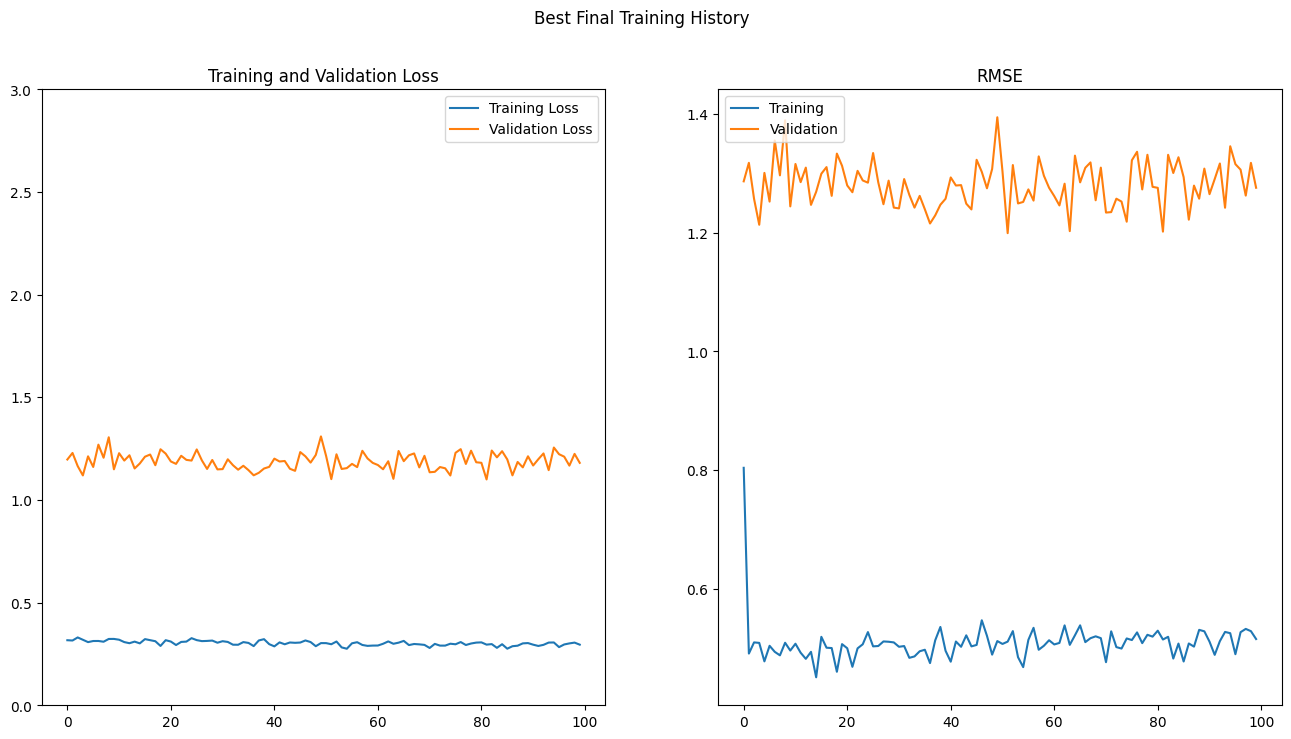

In [37]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = best_history_final.history['loss']
val_loss = best_history_final.history['val_loss']
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Best Final Training History")
ax = fig.add_subplot(rows, cols, 1)
ax.set_ylim(0, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

data = best_history_final.history['root_mean_squared_error']
val_data = best_history_final.history['val_root_mean_squared_error']
ax = fig.add_subplot(rows, cols, 2)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, data, label='Training')
plt.plot(epochs_range, val_data, label='Validation')
plt.legend(loc='upper left')
plt.title('RMSE')

### Testing Evalutaion

In [38]:
TOTAL_TEST = 0

for score_index, score in enumerate(score_labels):
    TOTAL_TEST += test_x_1[score].shape[0]

# com_test_x_1 = np.zeros(shape=(TOTAL_TEST, test_x_1[0.5].shape[1], test_x_1[0.5].shape[2]))
# com_test_x_2 = np.zeros(shape=(TOTAL_TEST, test_x_2[0.5].shape[1]))
com_test_x_P = np.zeros(shape=(TOTAL_TEST, 12))
com_test_y = np.zeros(shape=(TOTAL_TEST))
com_test_pred = np.zeros(shape=(TOTAL_TEST))

com_index = 0
for score_index, score in enumerate(score_labels):
    print(score)
    for index, x in enumerate(test_x_1[score]):
        # com_test_x_1[com_index] = test_x_1[score][index]
        # com_test_x_2[com_index] = test_x_2[score][index]
        individual_predictions = np.zeros(12)
        com_test_y[com_index] = score

        for score_index_2, score_2 in enumerate(score_labels):
            prediction = AllModels[score_2].predict(x=[np.array([test_x_1[score][index]]), np.array([test_x_2[score][index]])], verbose=0)
            individual_predictions[score_index_2] = prediction
        
        pred = best_model_final.predict(x=[
            np.array([test_x_1[score][index]]), 
            np.array([test_x_2[score][index]]), 
            np.array([individual_predictions])
            ],
            verbose=0
        )

        com_test_pred[com_index] = pred
        com_index += 1

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0


In [39]:
#print(com_test_pred - com_test_y)
np.sqrt(np.mean((com_test_pred-com_test_y)**2))

0.8828445449071028

## Generating Predictions

In [59]:
# 2c75e15a --> 4.0
# 2c7997a3 --> 3.5
# 2d299968 --> 5.0
# test_logs = pd.read_csv("./data/personaltest.csv")

predictions = []
x_pred, x2_pred = DfToX(test_logs)
BinaryScorePredictions = np.array([
    AllModels[0.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[1.0].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[1.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[2.0].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[2.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[3.0].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[3.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[4.0].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[4.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[5.0].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[5.5].predict(x=[x_pred, x2_pred], verbose=0),
    AllModels[6.0].predict(x=[x_pred, x2_pred], verbose=0)
])
print(BinaryScorePredictions.shape)
BinaryScorePredictions = np.transpose(BinaryScorePredictions, axes=(1, 0, 2))
print(BinaryScorePredictions)

predictions_final = best_model_final.predict(x=[x_pred, x2_pred, BinaryScorePredictions], verbose=0)
predictions = []
for index, id in enumerate(test_logs["id"].unique()):
    pred_score = 3.5
    try:
        pred_score = predictions_final[index][0]
        print(pred_score)
    except ValueError as ex:
        pred_score = 3.5
        print(f"VALUE ERROR OCCURED. ERROR: {ex}")
    except Exception as ex:
        print(f"ERROR: {ex}")
        pred_score = 3.5
    finally:
        predictions.append((id, pred_score))

ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]

sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)

(12, 3, 1)
[[[0.0000000e+00]
  [0.0000000e+00]
  [6.4109772e-01]
  [0.0000000e+00]
  [0.0000000e+00]
  [7.6639469e-07]
  [1.3922142e-02]
  [3.7426889e-01]
  [1.4090218e-04]
  [3.6333784e-19]
  [0.0000000e+00]
  [0.0000000e+00]]

 [[6.0539645e-01]
  [0.0000000e+00]
  [6.4109772e-01]
  [0.0000000e+00]
  [0.0000000e+00]
  [3.7321699e-06]
  [9.9021327e-01]
  [7.2135609e-01]
  [5.8837420e-01]
  [5.6128991e-01]
  [6.4927286e-01]
  [7.7372025e-10]]

 [[0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  [1.8275183e-04]
  [4.2746461e-08]
  [7.2134328e-01]
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]
  [0.0000000e+00]]]
3.6807334
3.705322
3.6399546


## Timing

In [40]:
totaltime2 = time.time()
print(totaltime2 - totaltime1)

3293.5747220516205


In [41]:
print((totaltime2-totaltime1)/60)

54.89291203419368
